#  Reinforcement Learning part 2: Generalizability, Q-Learning enhancements and function approximators

Reinforcement Learning is a general framework for building computational agents which can, if trained properly, act intelligently in a well-defined but dynamic environment.  Interesting applications of this paradigm include game AI (e.g., AlphaGo and self-playing Atari and Nintendo games), as well as various challenging problems in mechanical control and robotics.

In this notebook we continue our introduction to the fundamentals of Reinforcement Learning and discuss:

- several important enhancements to Q-Learning
- the strengths and shortcomings of a fully trained agent
- large state spaces and the necessity for generic function approximators (e.g., kernels, neural networks, and trees)


>The content of this notebook is supplementary material for the textbook Machine Learning Refined (Cambridge University Press, 2016). Visit http://www.mlrefined.com for free chapter downloads and tutorials, and [our Amazon site here](https://www.amazon.com/Machine-Learning-Refined-Foundations-Applications/dp/1107123526/ref=sr_1_1?ie=UTF8&qid=1474491657&sr=8-1&keywords=machine+learning+refined) for details regarding a hard copy of the text.

#  1.  How generalizable is a trained agent?

At the end of the last notebook we trained a fully-functional gridworld agent on a maze world.  Lets reproduce that result quickly for easy reference.  We initialize the gridworld in the next cell, train it in the second cell using the basic Q-Learning algorithm discussed in the previous notebook, and use the learned optimal policy function to move effeciently through the maze starting at a number of intitial locations.

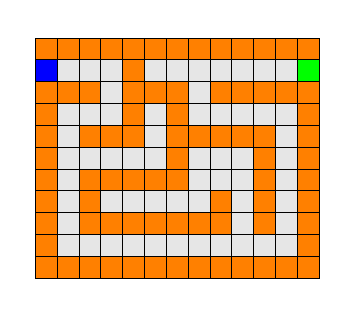

In [1]:
# import gridworld library - make sure this is executed prior to running any gridworld cell
import sys
sys.path.append('demo_python_backend_files')
%matplotlib inline

# import custom gridworld simulator 
from gridworld_lib import gridworld_enviro

# generate instance of gridworld
small_maze = gridworld_enviro.environment(world_size = 'small', world_type = 'maze')

# show the grid
small_maze.color_gridworld()

In [3]:
# import q-learning module
from gridworld_lib import gridworld_qlearn

# create an instance of the q-learner
small_maze_qlearner = gridworld_qlearn.learner(gridworld = small_maze,action_method = 'random')

# run q-learning
small_maze_qlearner.train(verbose = True)

training episode 50 of 500 complete
training episode 100 of 500 complete
training episode 150 of 500 complete
training episode 200 of 500 complete
training episode 250 of 500 complete
training episode 300 of 500 complete
training episode 350 of 500 complete
training episode 400 of 500 complete
training episode 450 of 500 complete
training episode 500 of 500 complete
q-learning algorithm complete



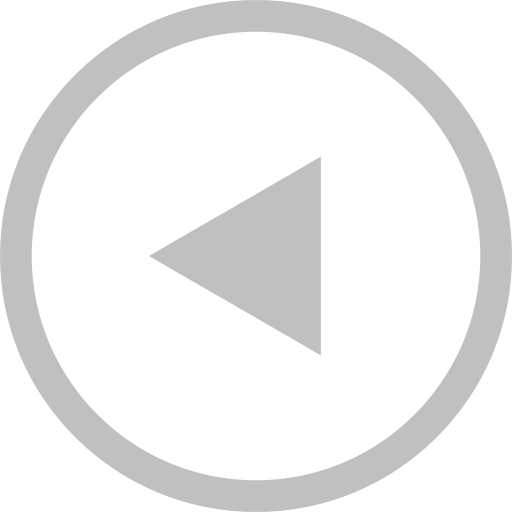
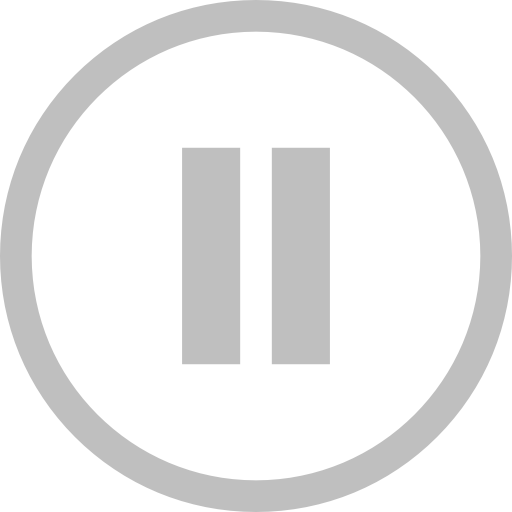
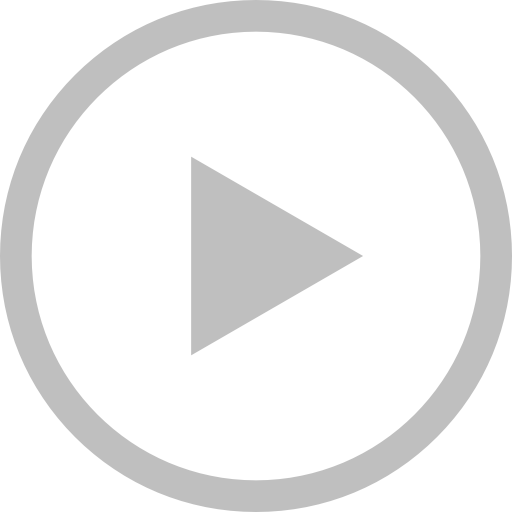
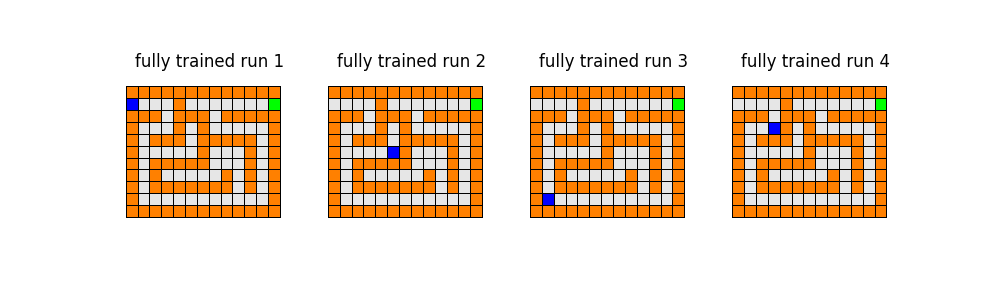
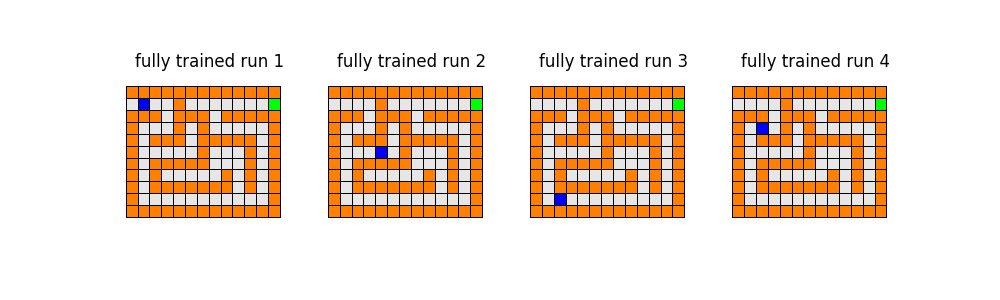
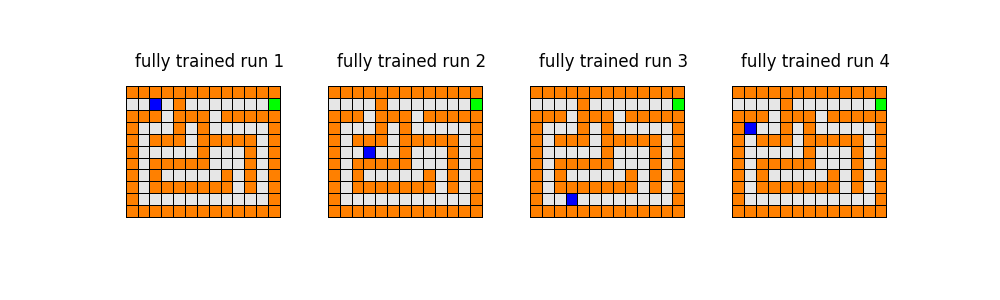
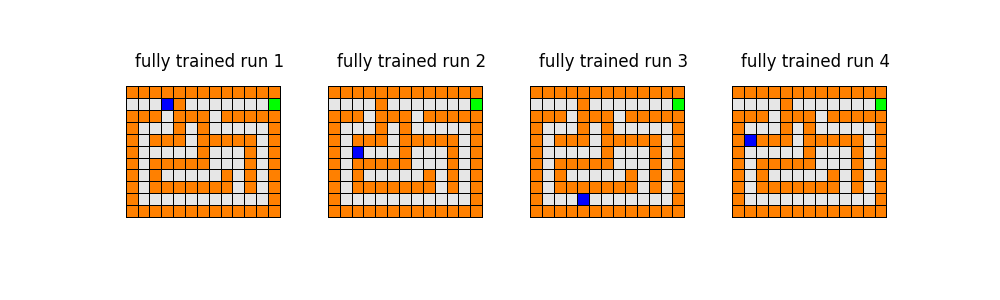
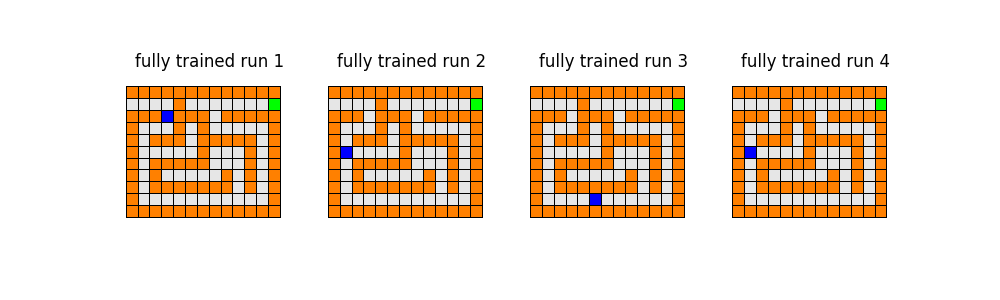
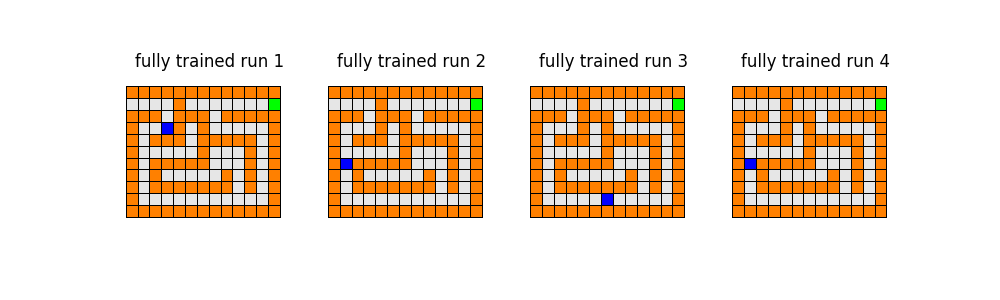
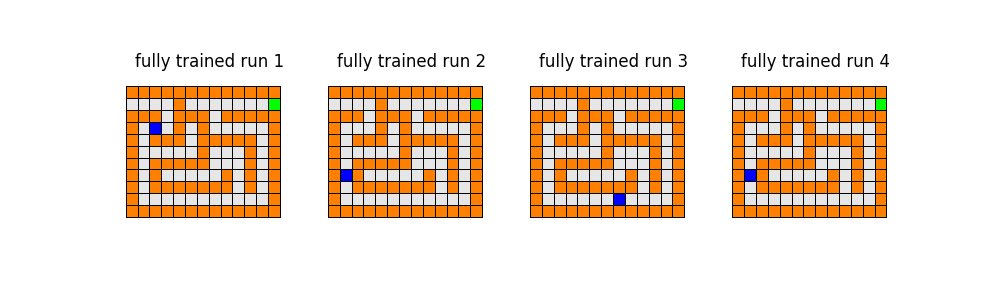
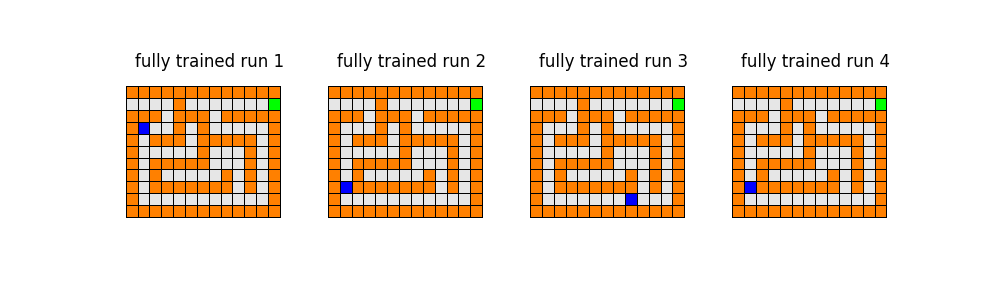
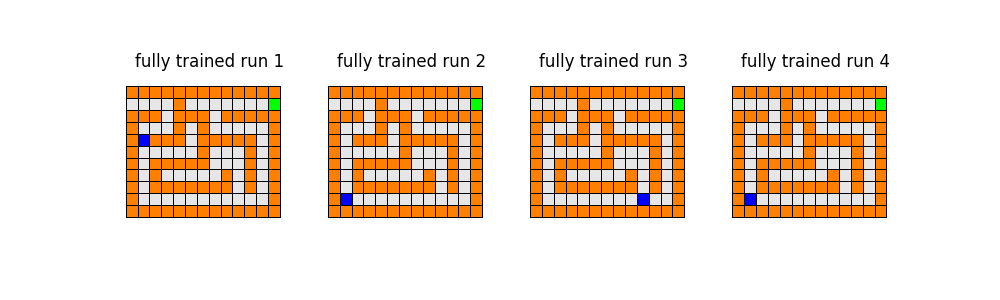
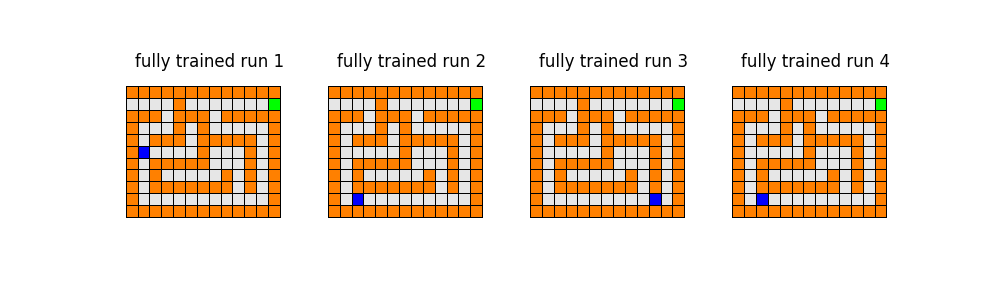
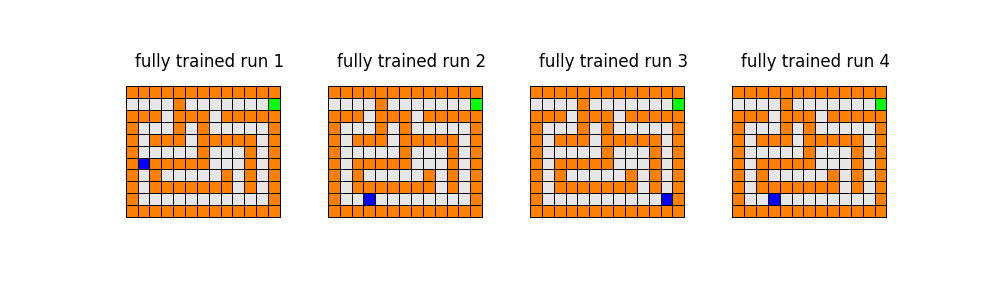
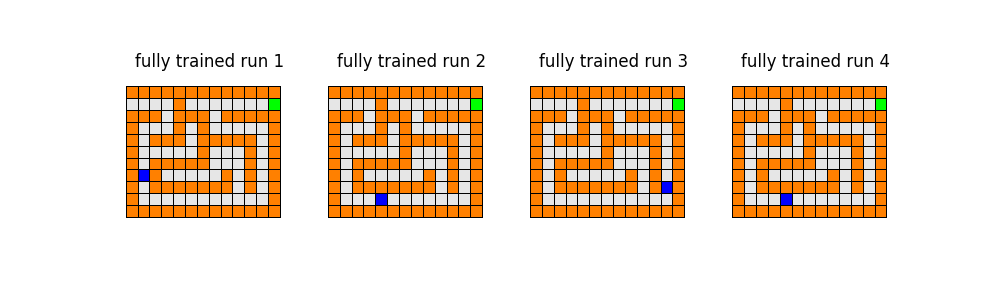
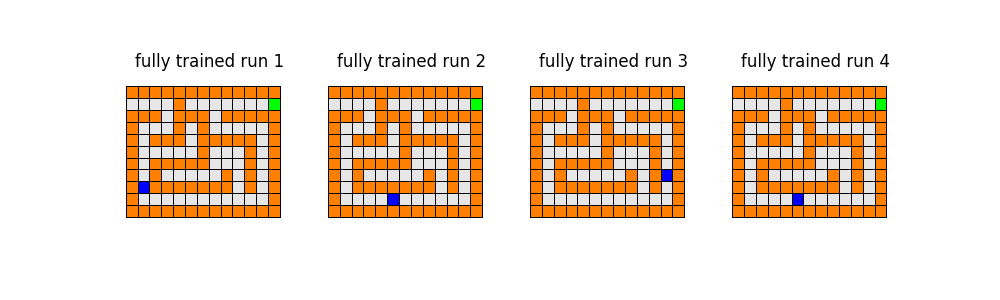
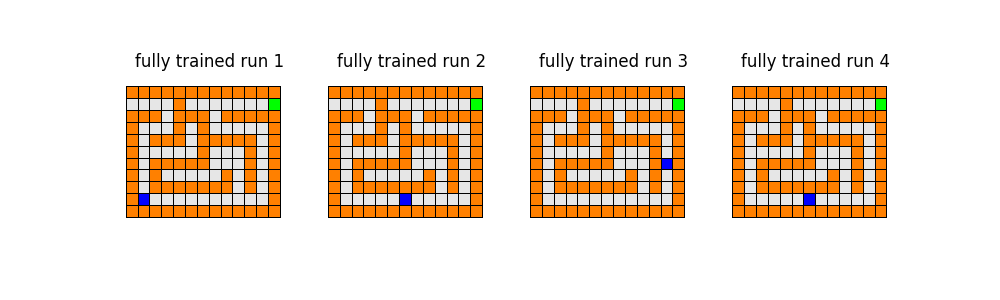
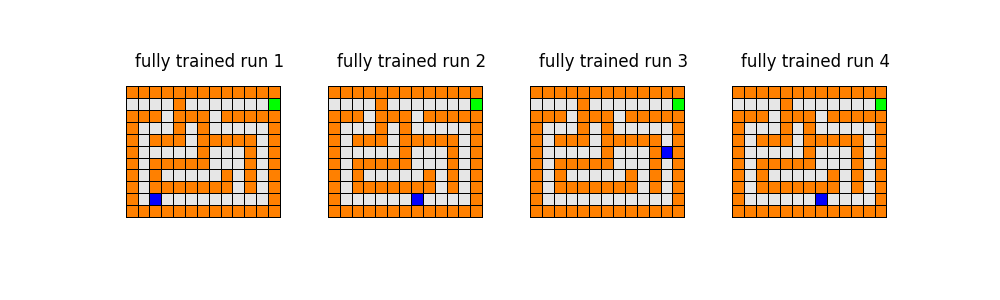
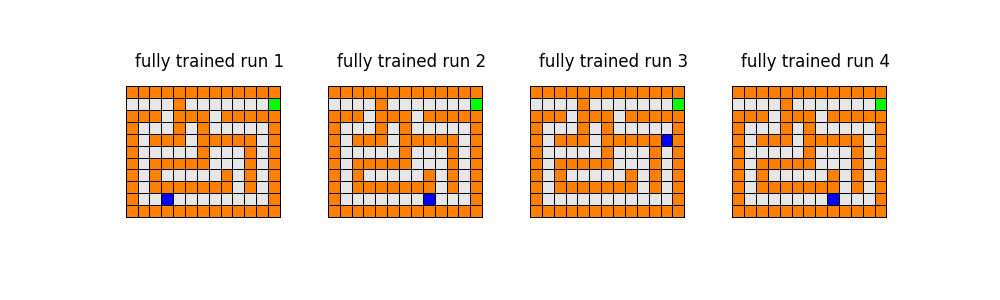
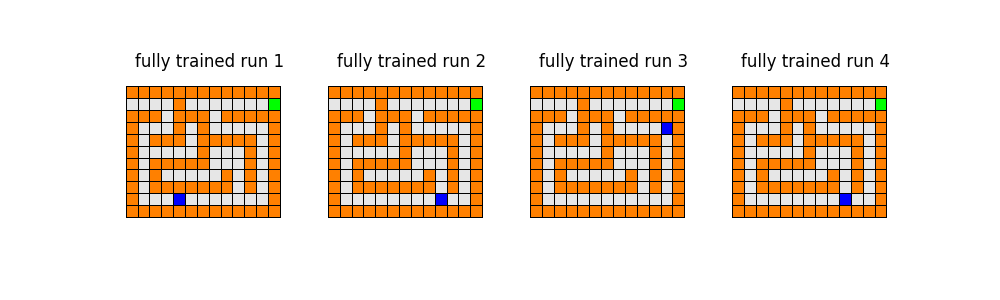
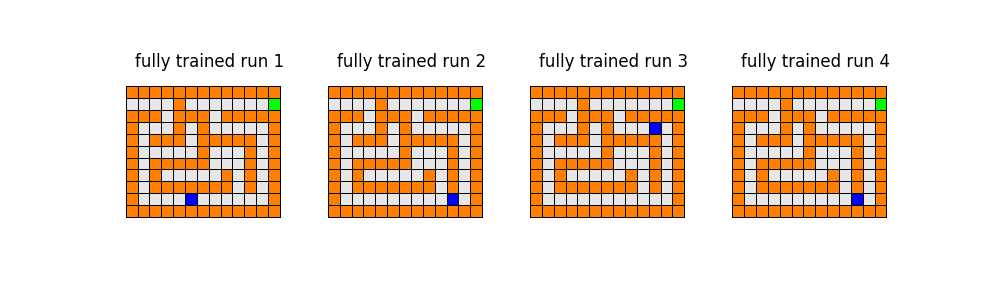
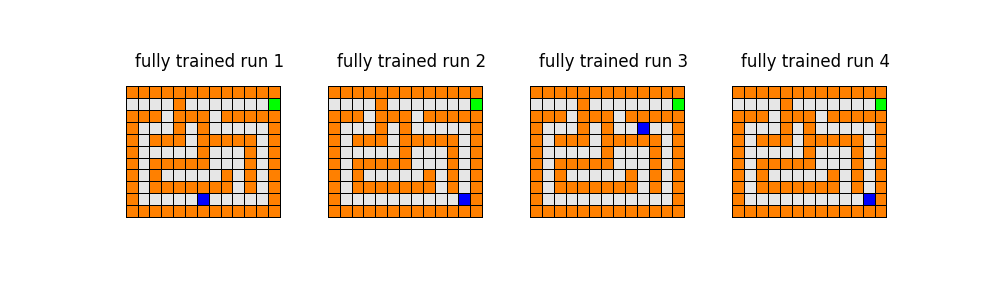
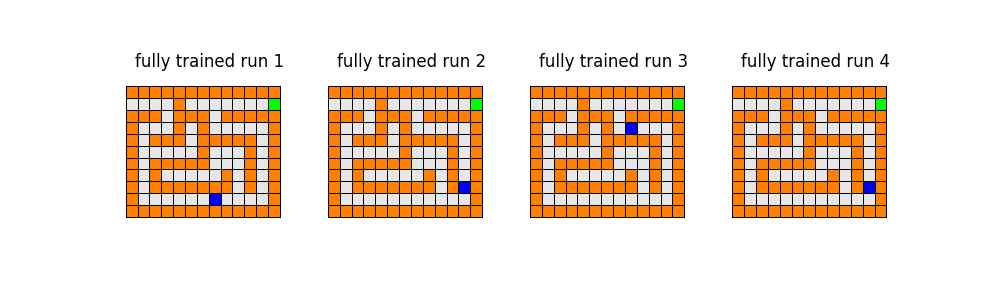
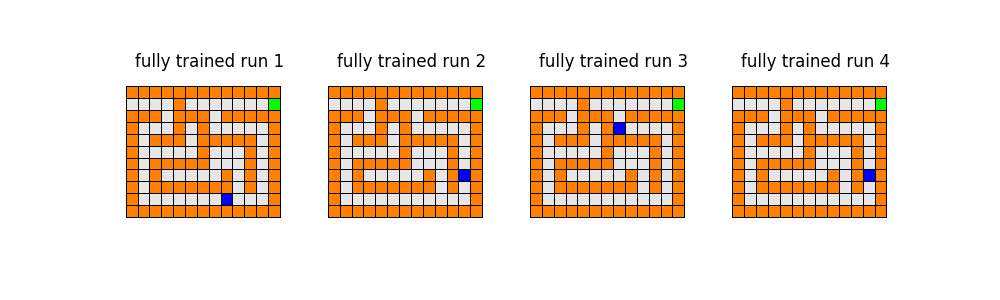
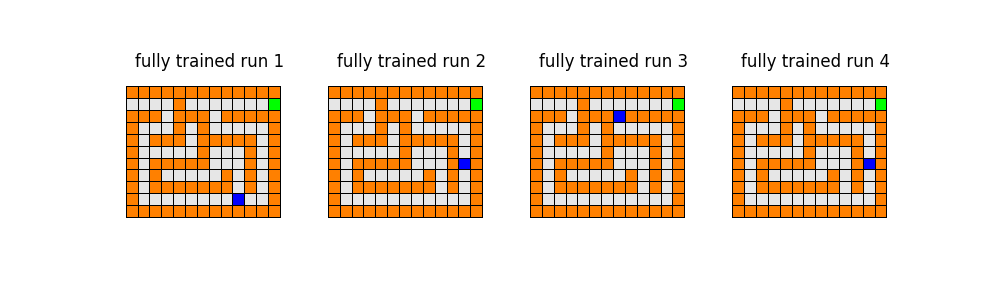
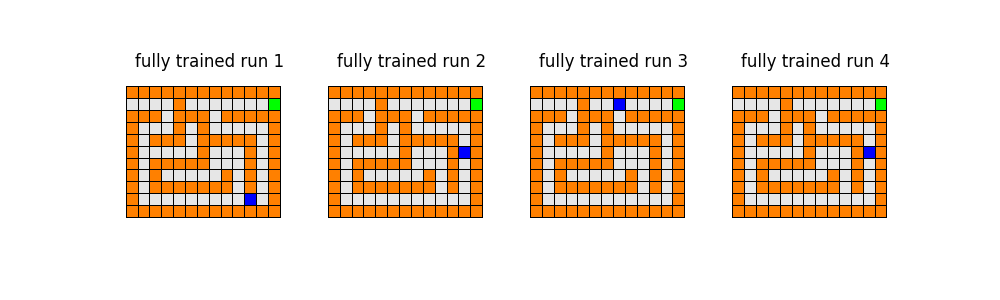
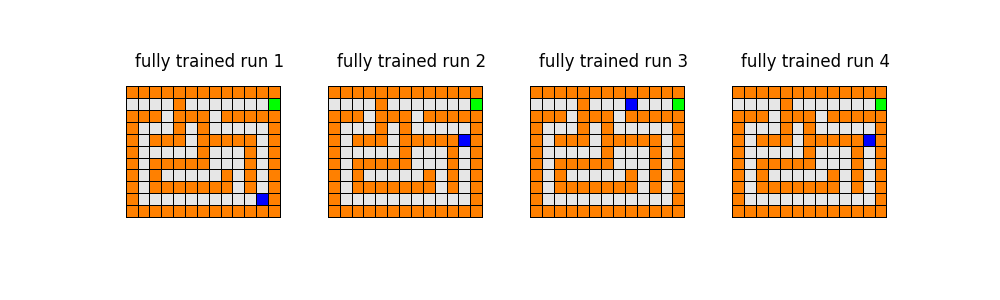
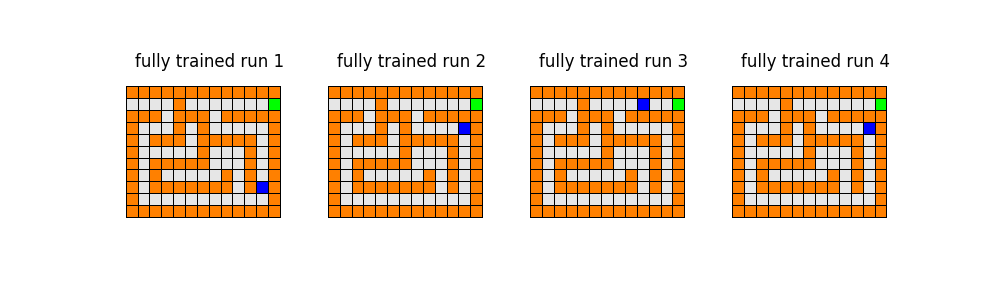
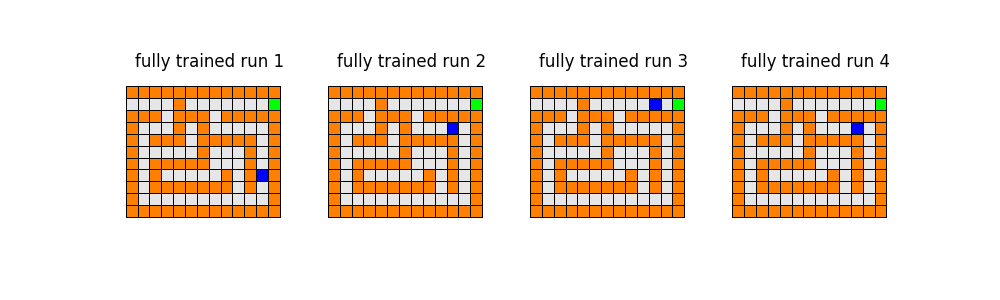
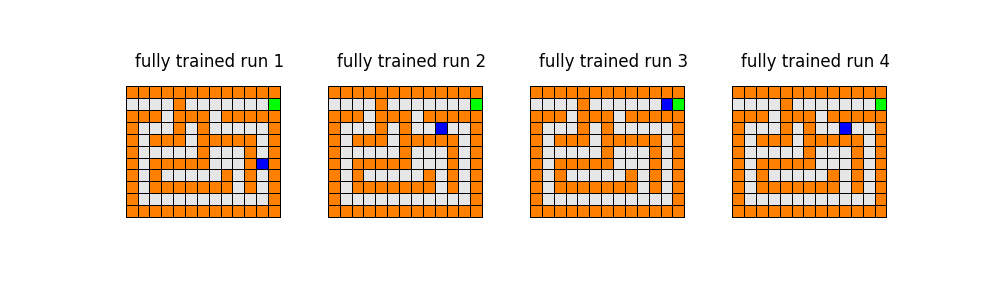
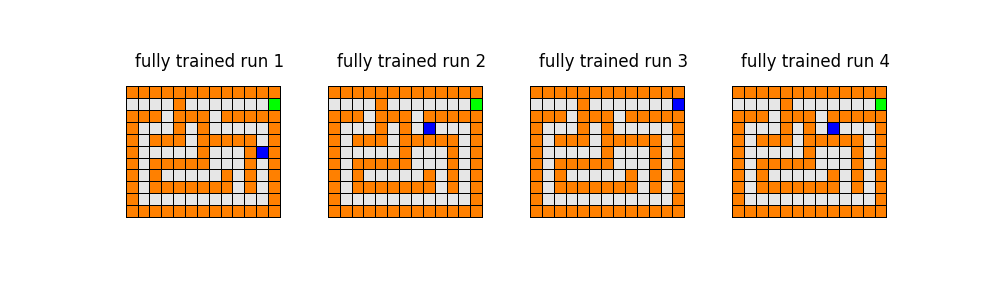
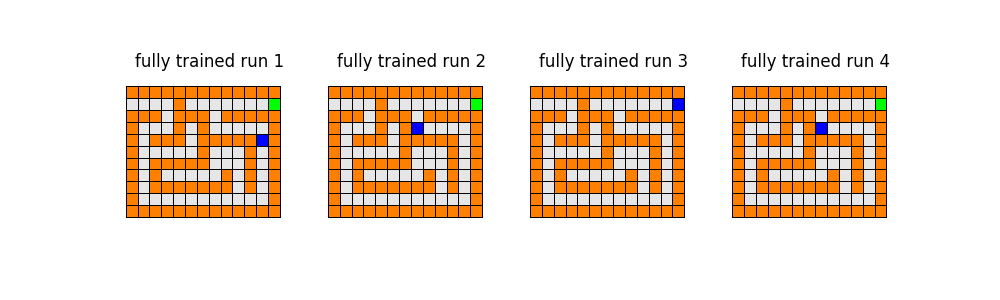
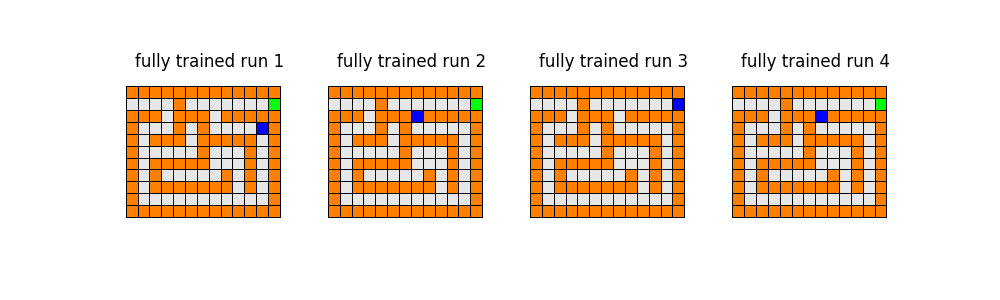
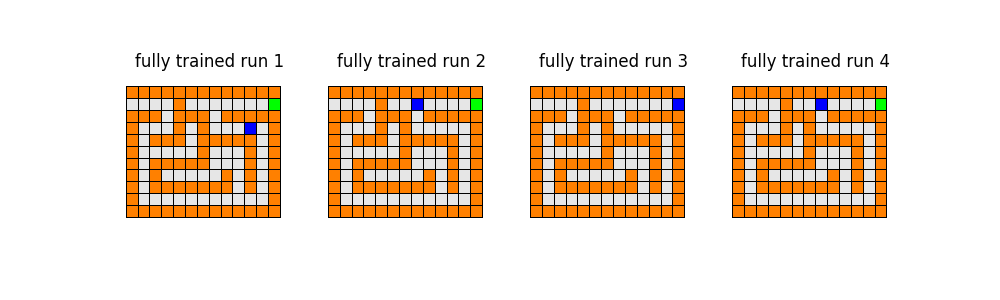
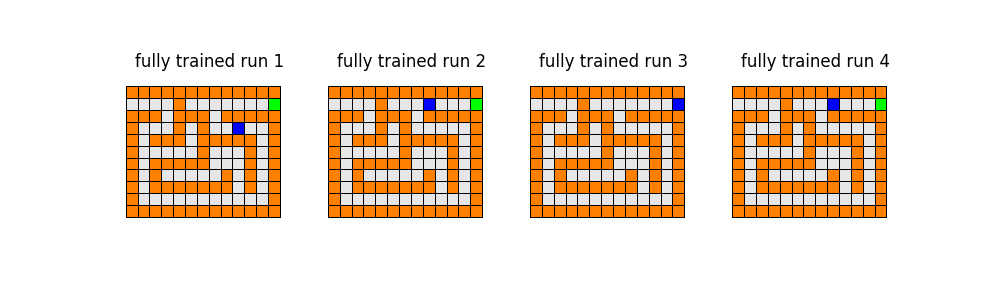
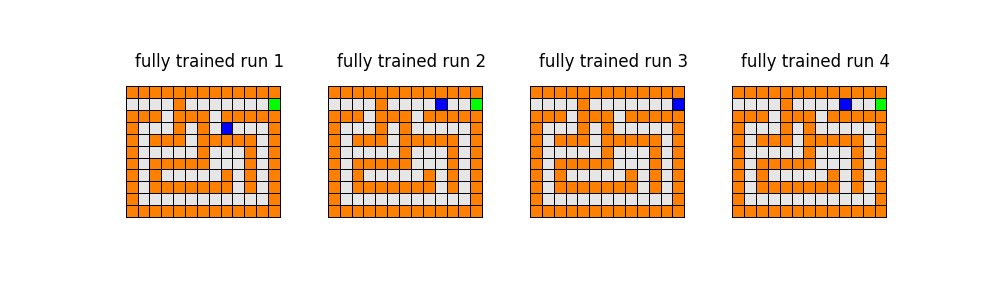
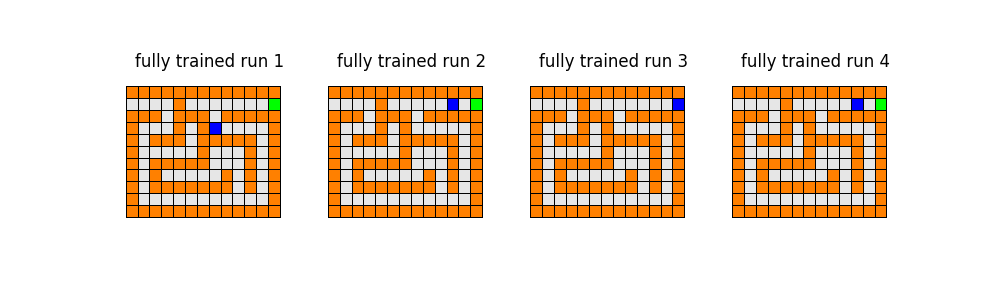
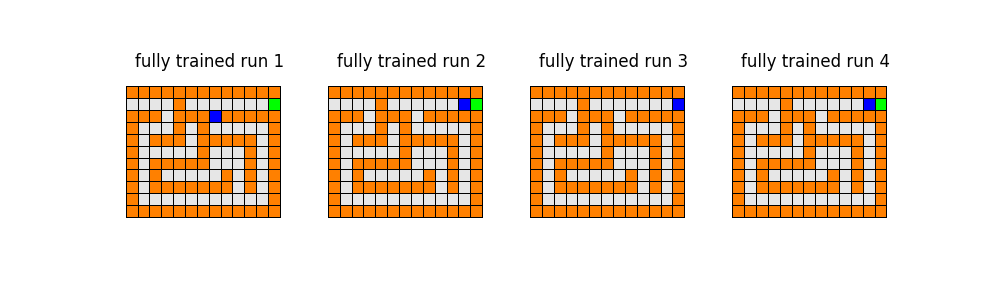
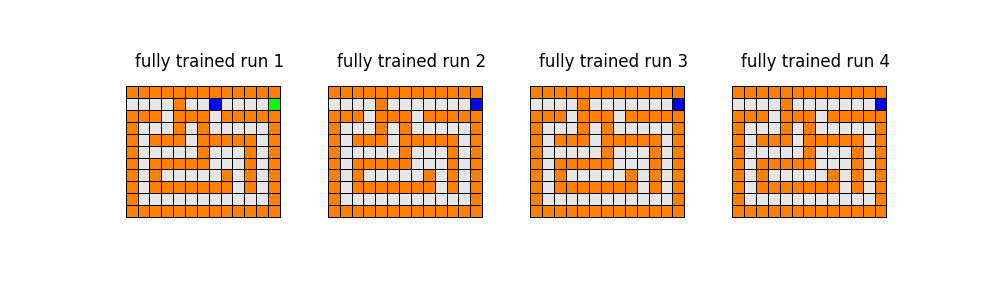
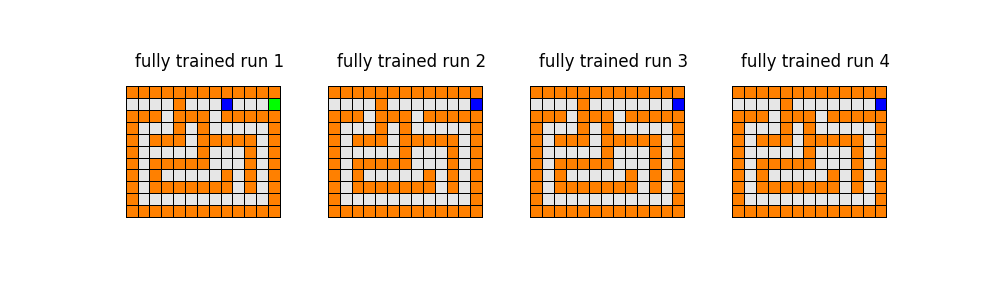
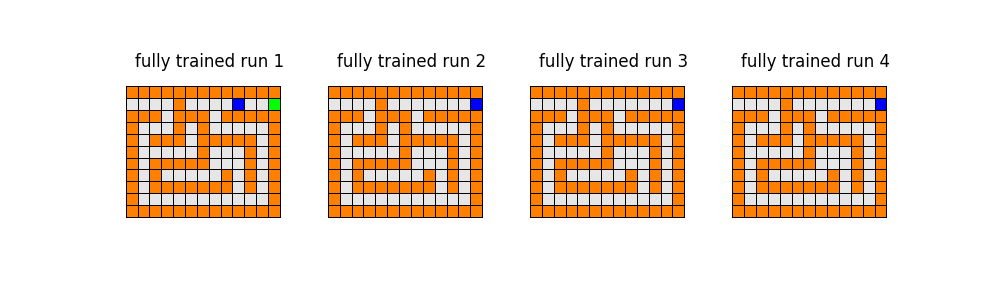
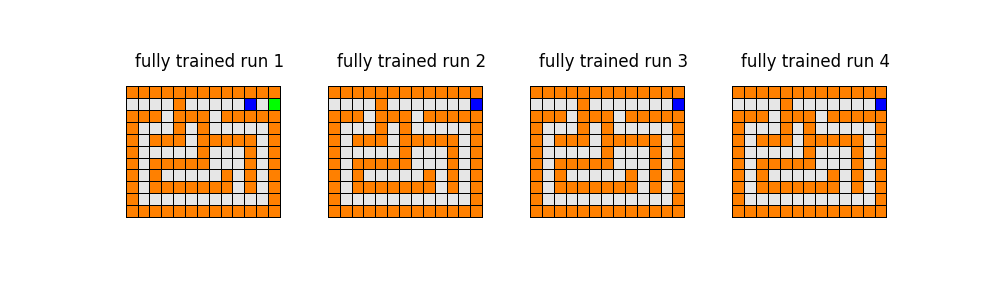
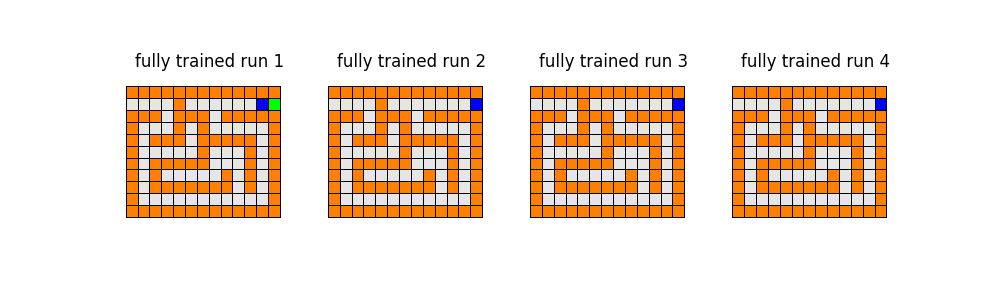
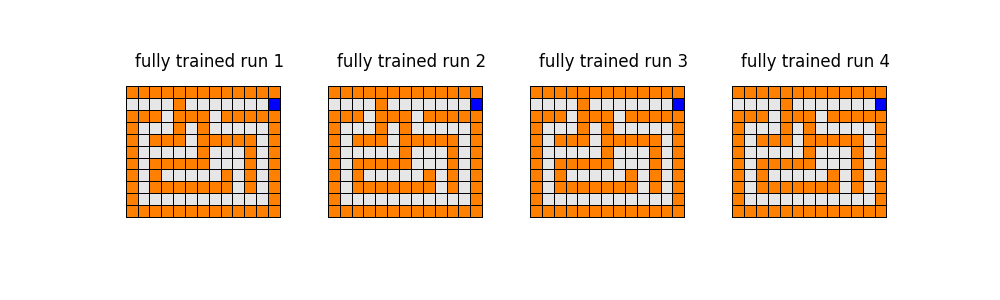

In [4]:
# load in gridworld animation module
from gridworld_lib import gridworld_animators

# create instance of animator
animator = gridworld_animators.animator()

# animate a fully trained agent 
locs = [[9,0],[5,5],[1,1],[7,3]]
animator.animate_validation_runs(gridworld = small_maze,learner = small_maze_qlearner,starting_locations = locs)

Works quite well!

How well will our trained agent - trained on the maze enviroment - perform if we set it loose on a different enviroment?  Lets experiment and find out.  Below we load in the 'moat' world and set our learned agent loose on it.

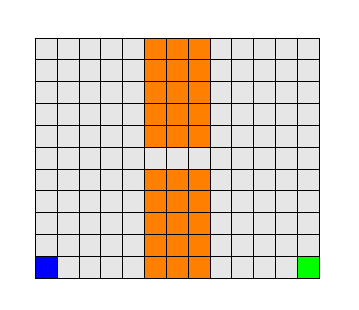

In [5]:
# import custom gridworld simulator 
from gridworld_lib import gridworld_enviro

# generate instance of gridworld
small_moat = gridworld_enviro.environment(world_size = 'small', world_type = 'moat')

# show the enviroment
small_moat.color_gridworld()


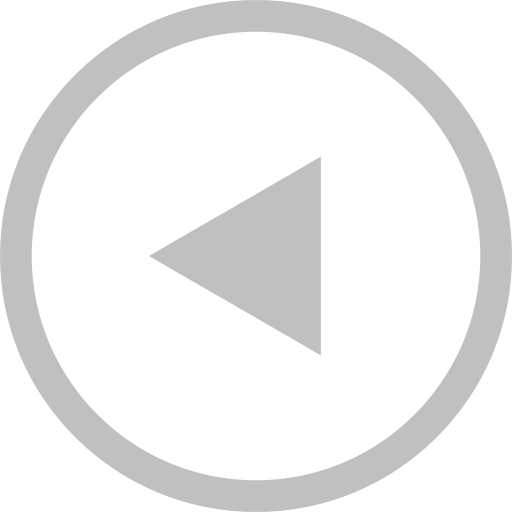
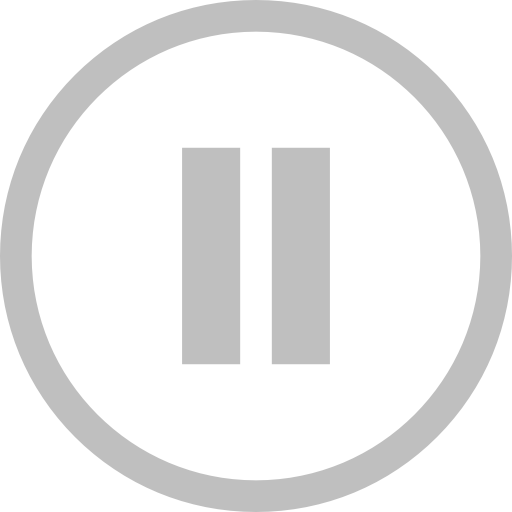
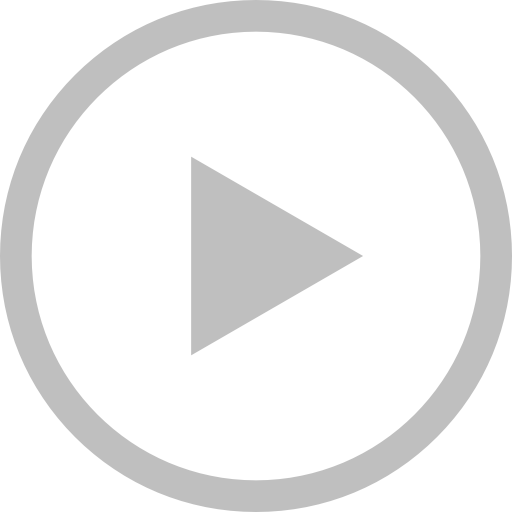
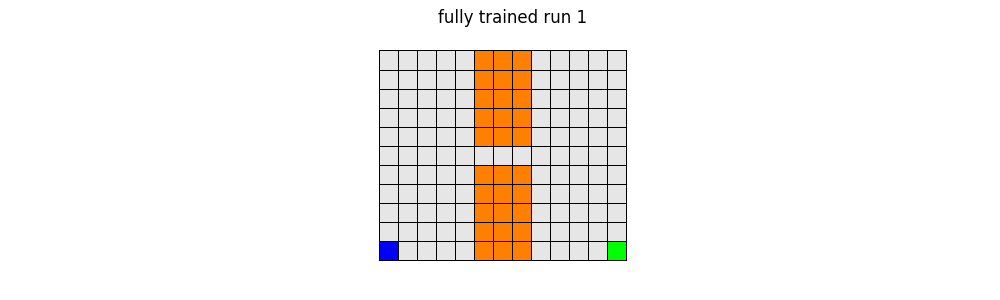
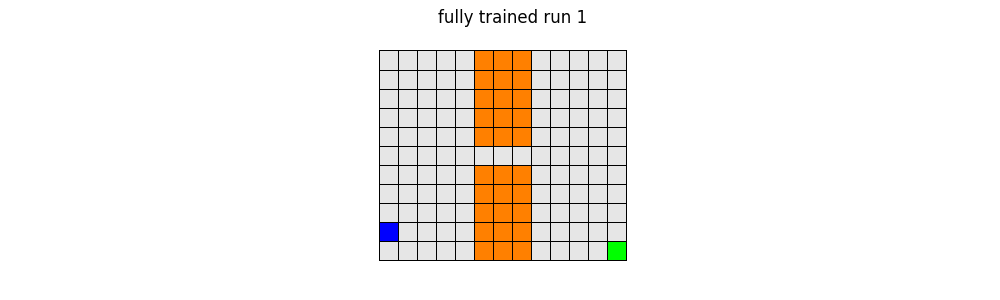
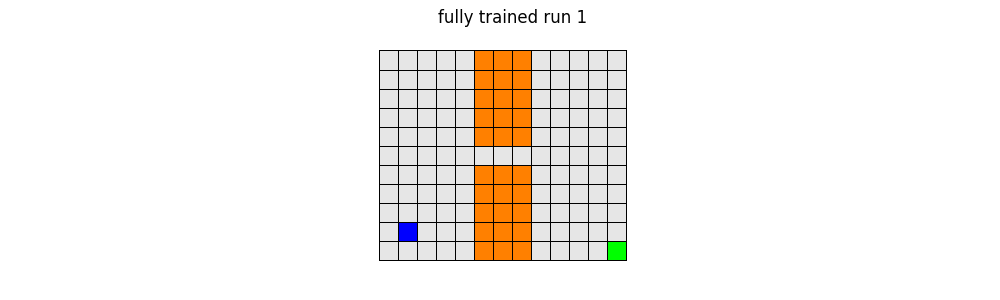
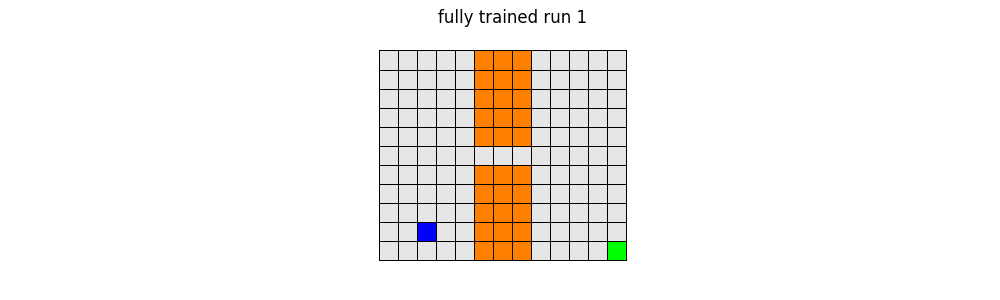
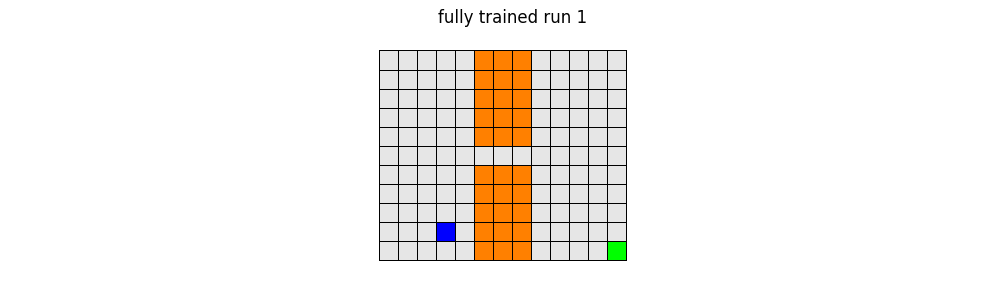
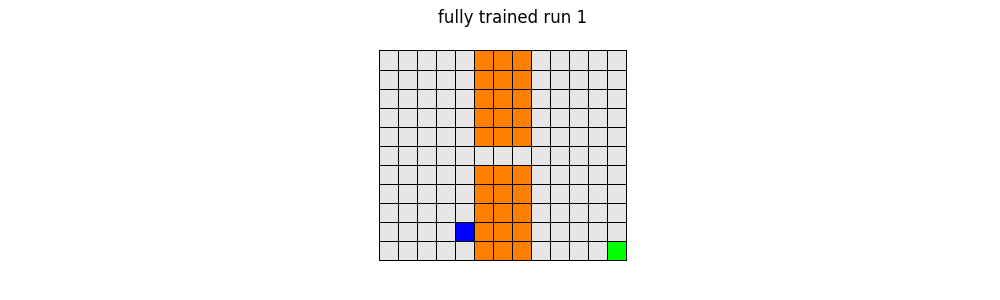
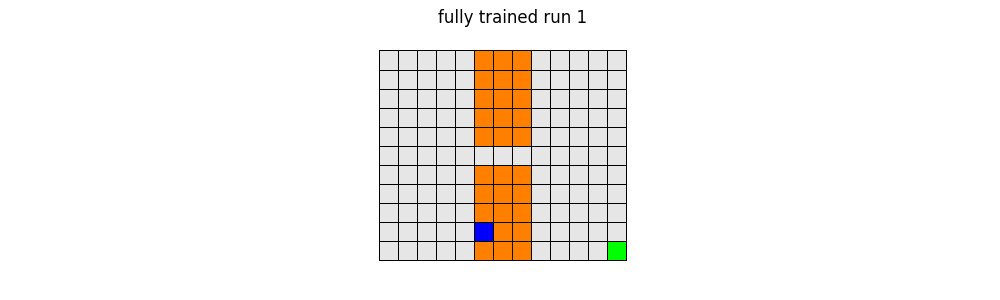
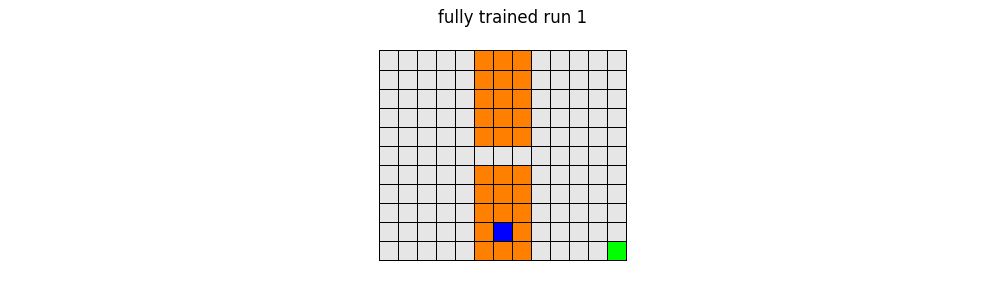
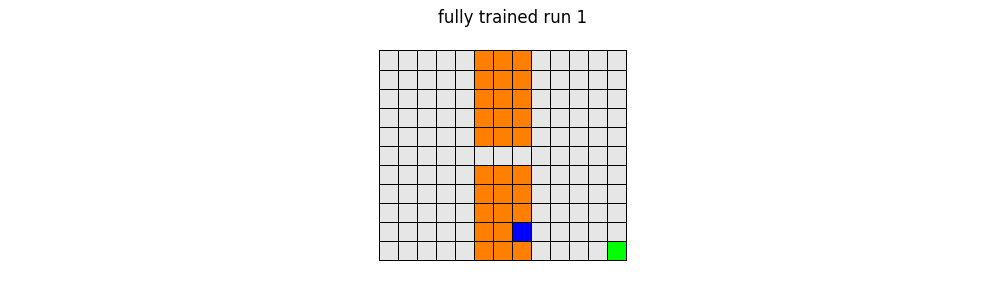
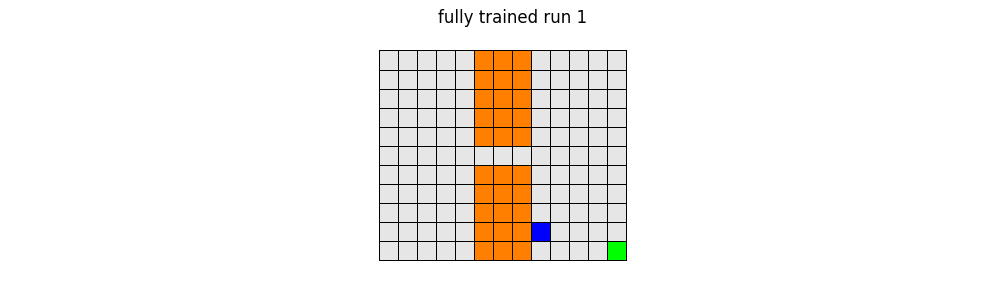
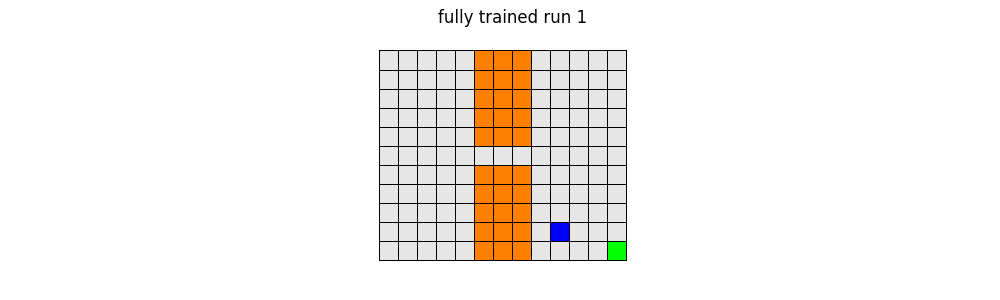
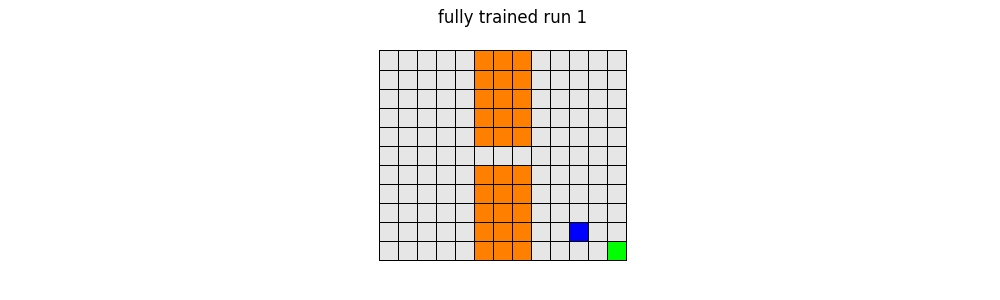
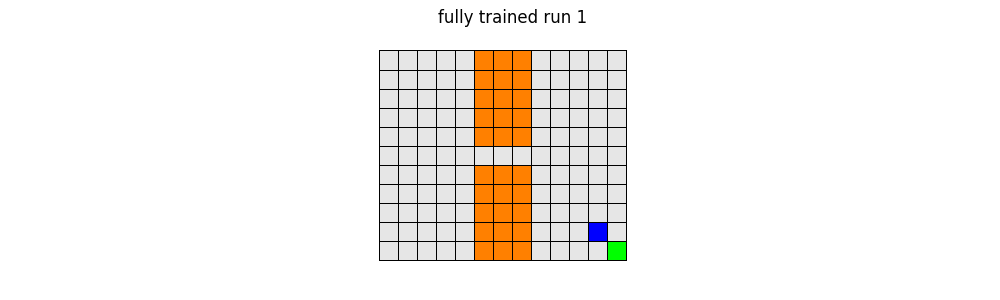
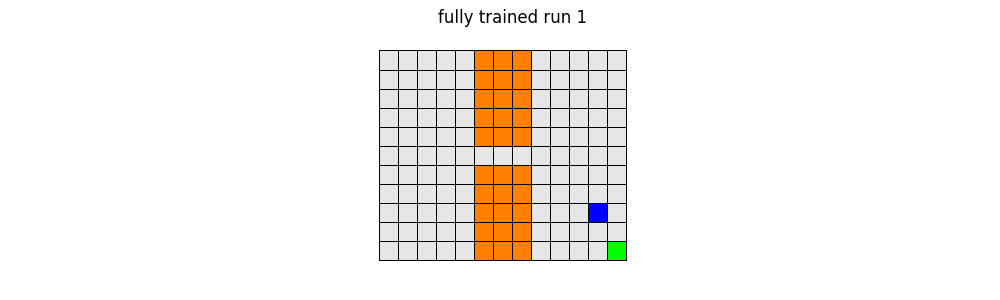
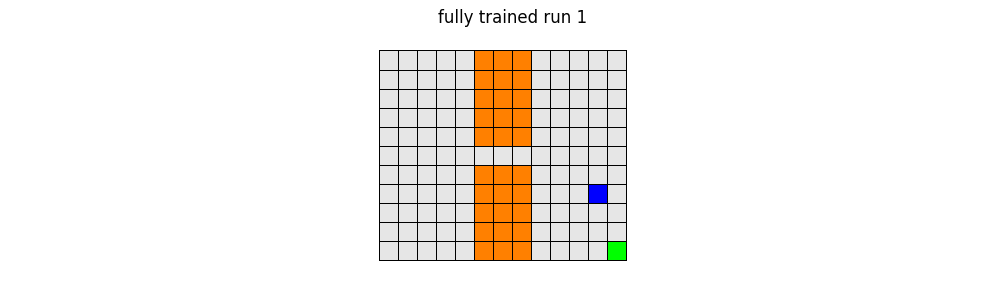
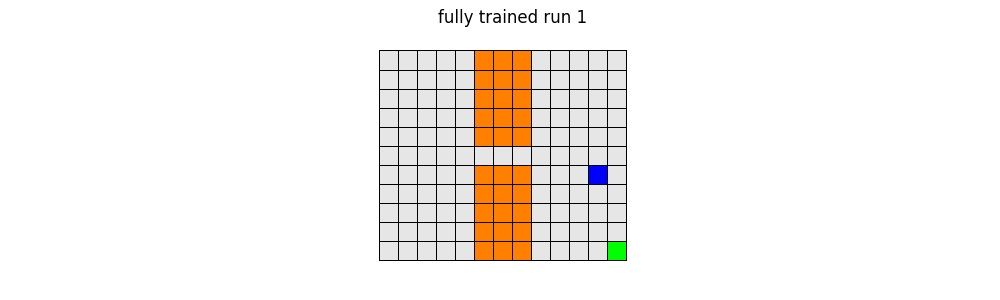
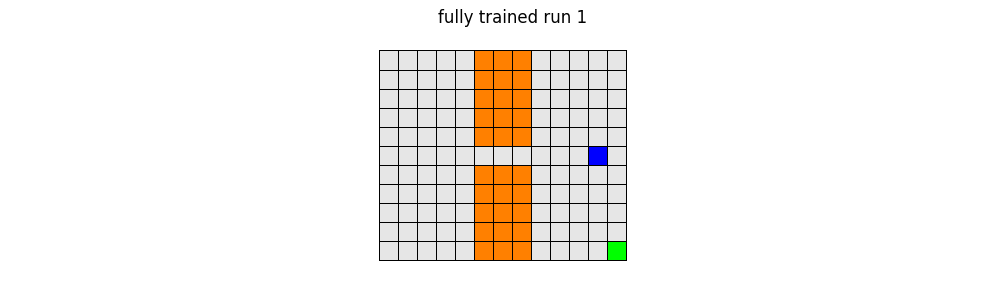
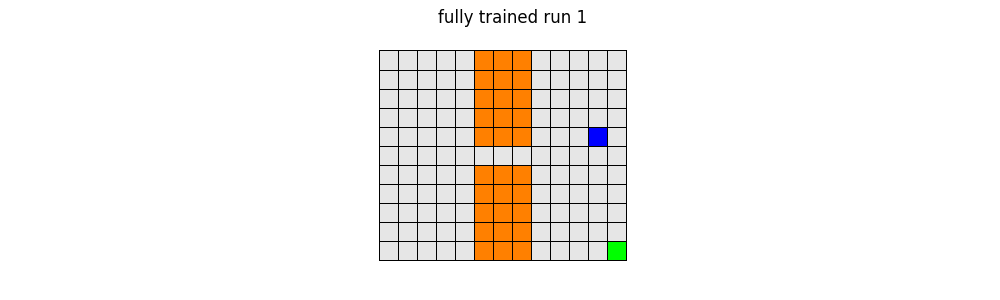
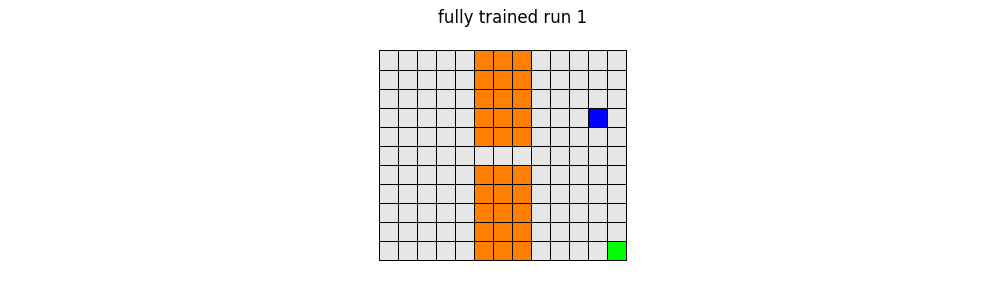
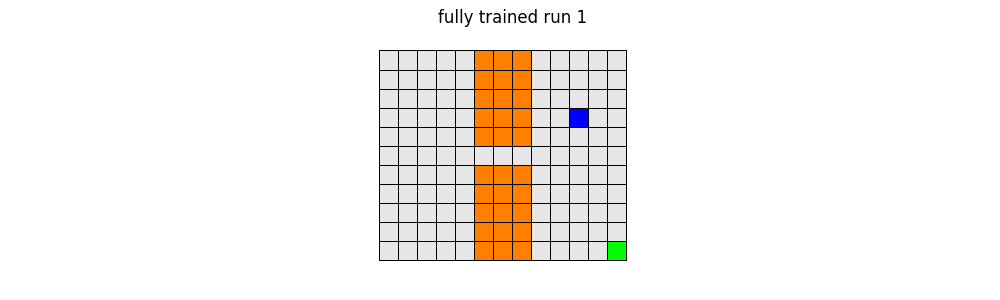
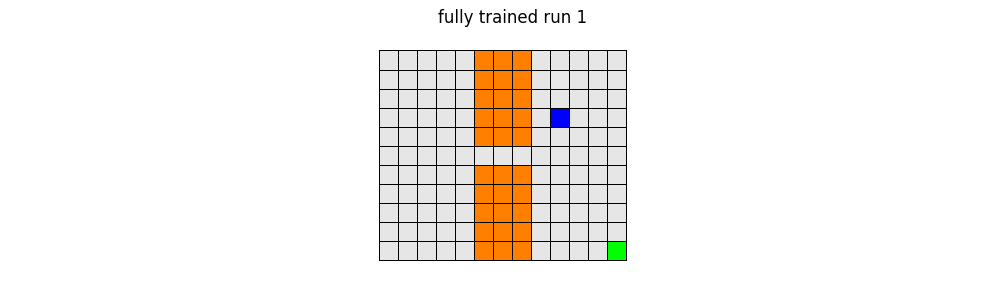
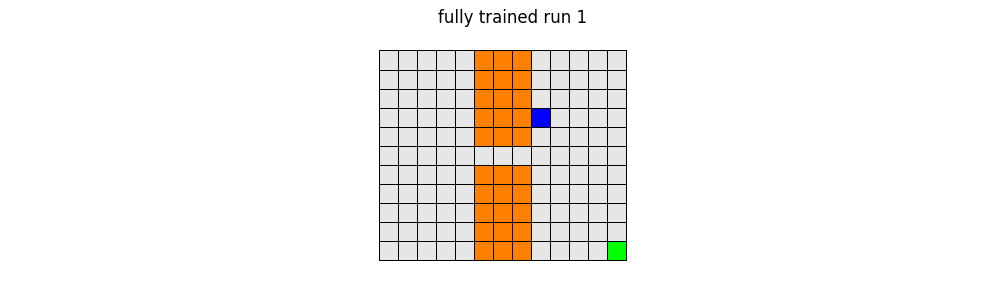
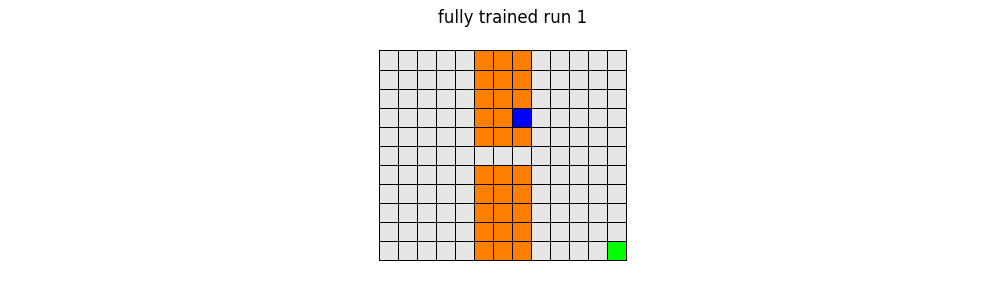
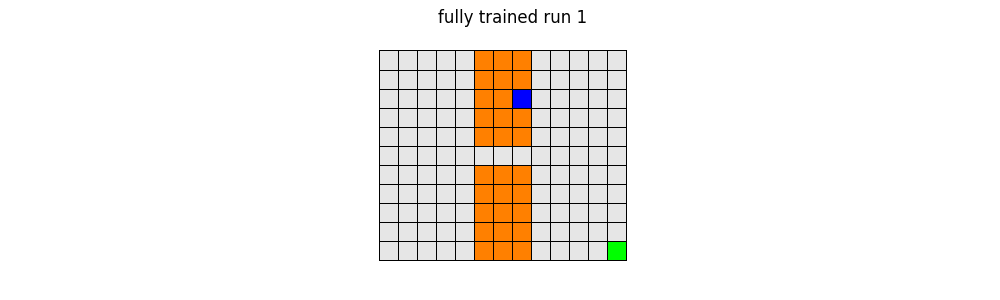
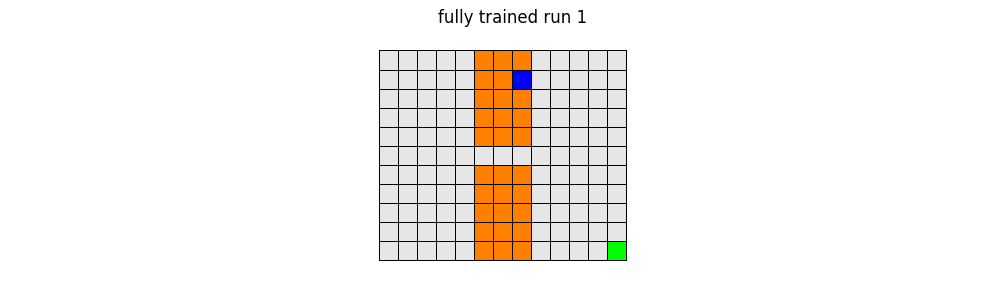
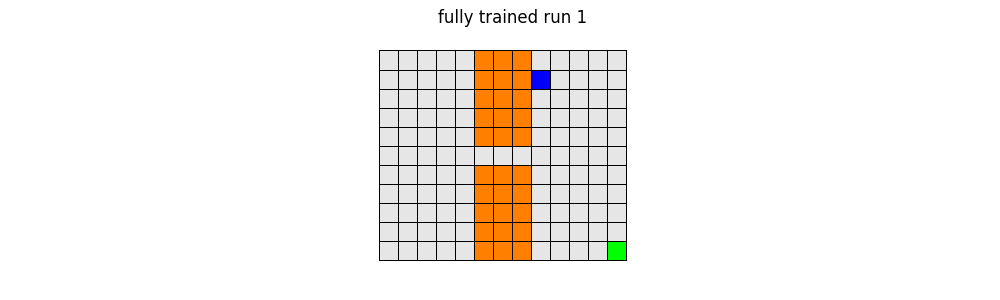
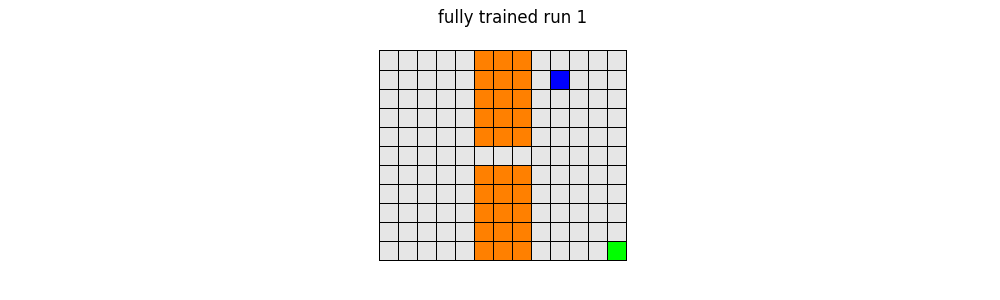
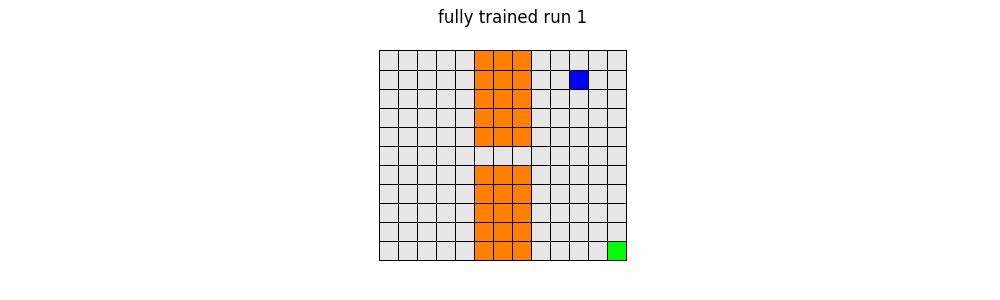
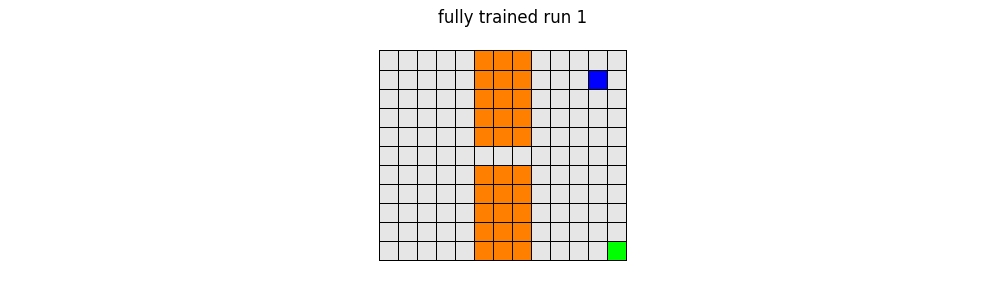
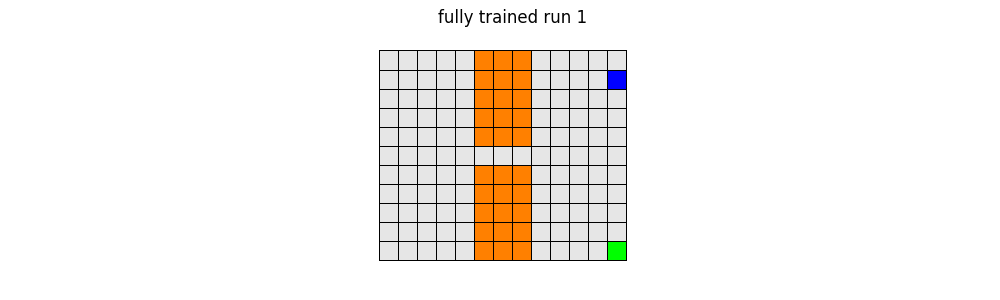
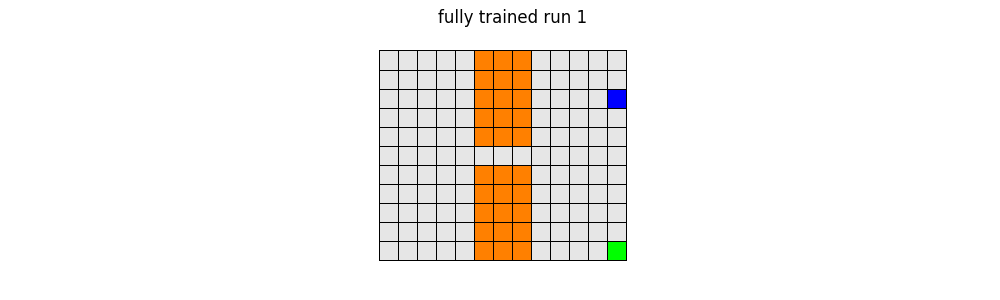
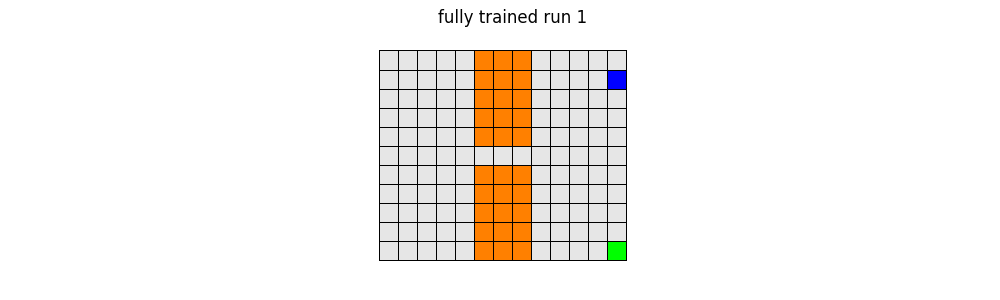
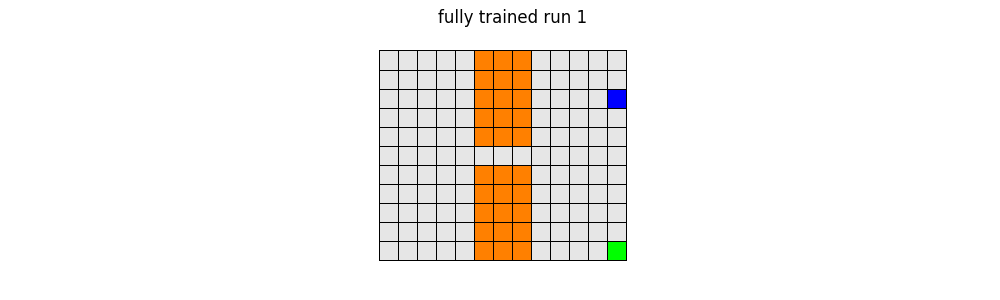
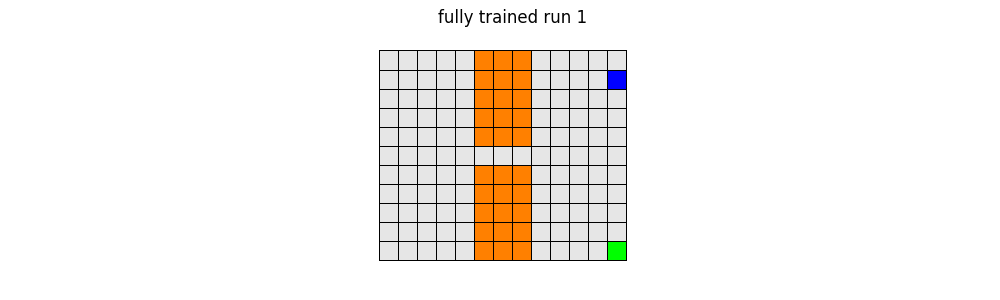
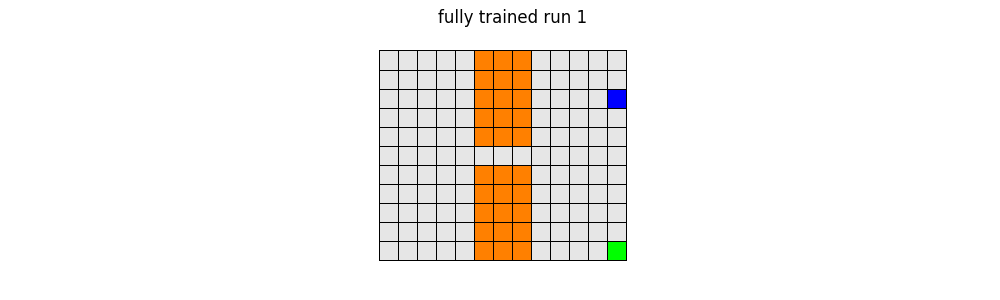
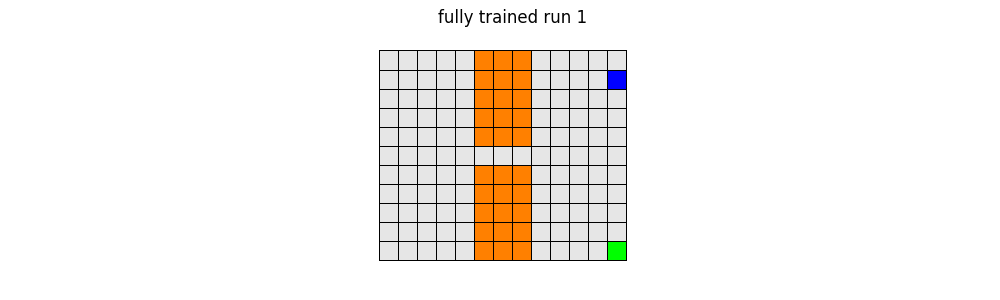
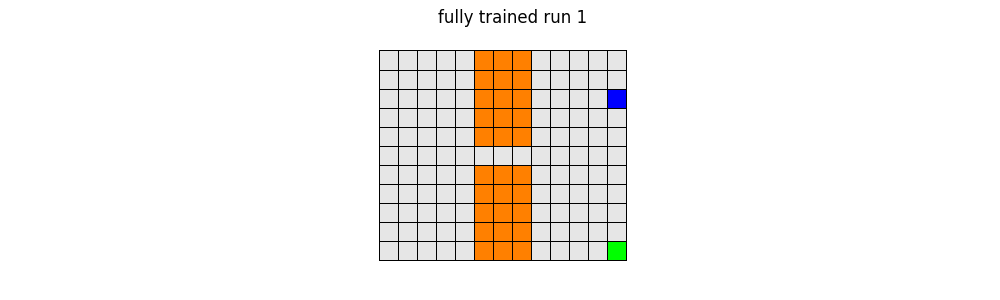
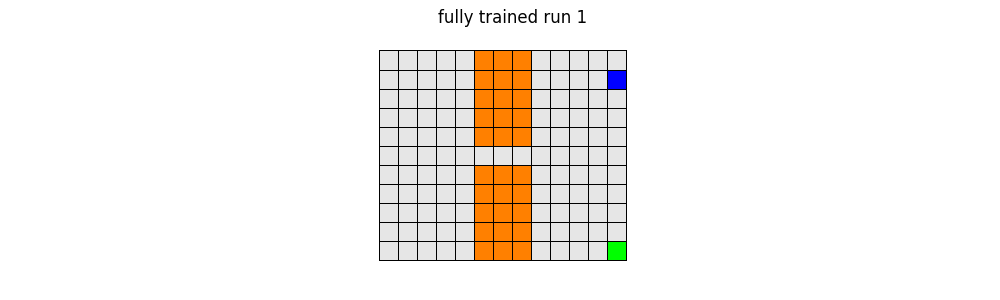
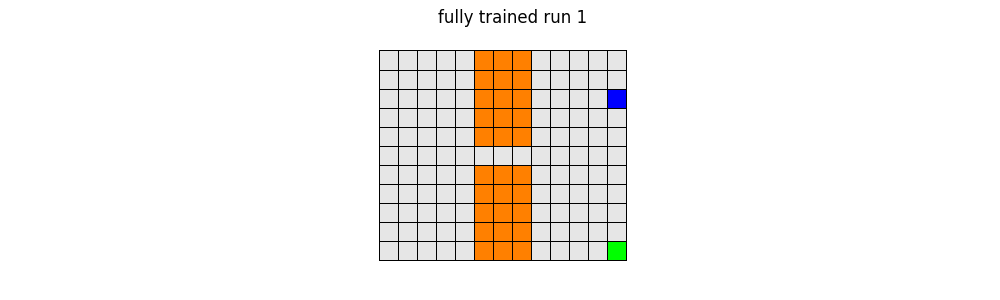
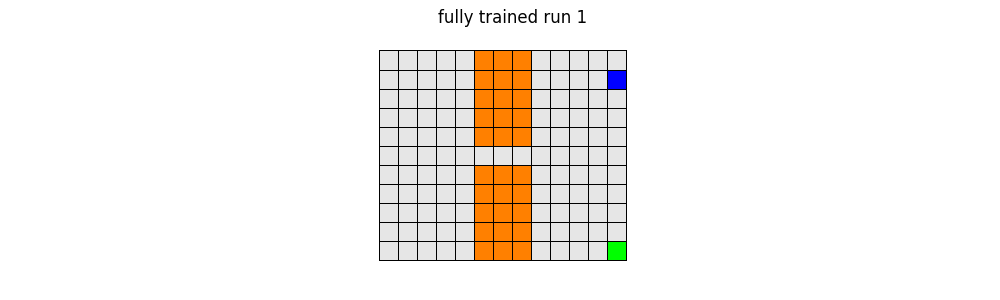
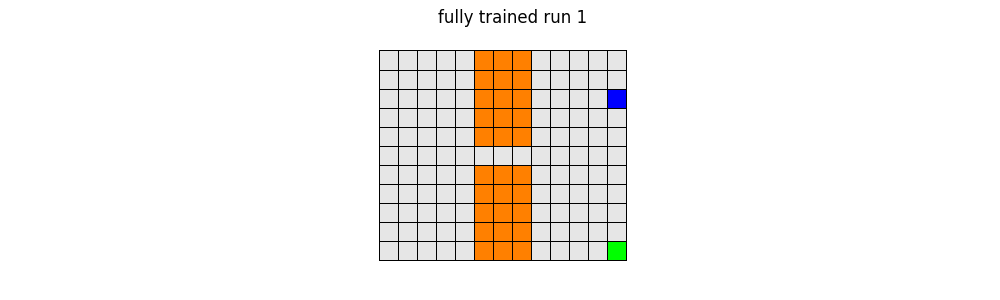
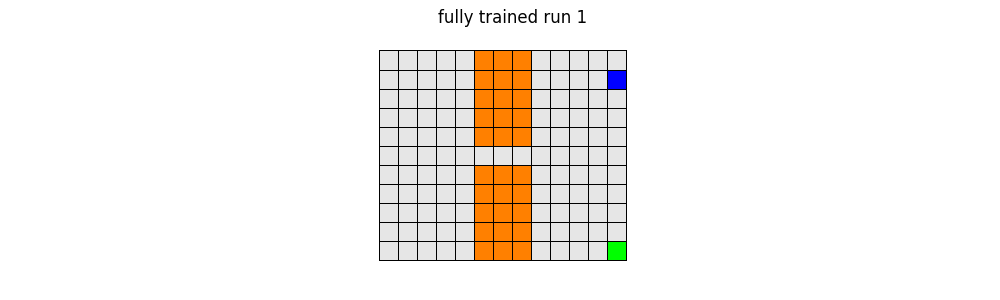
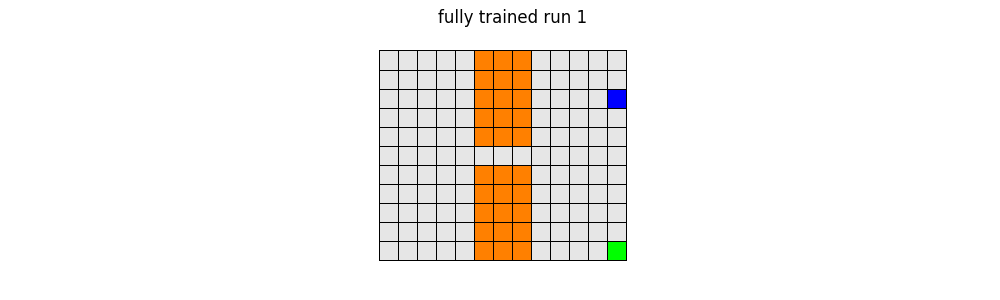
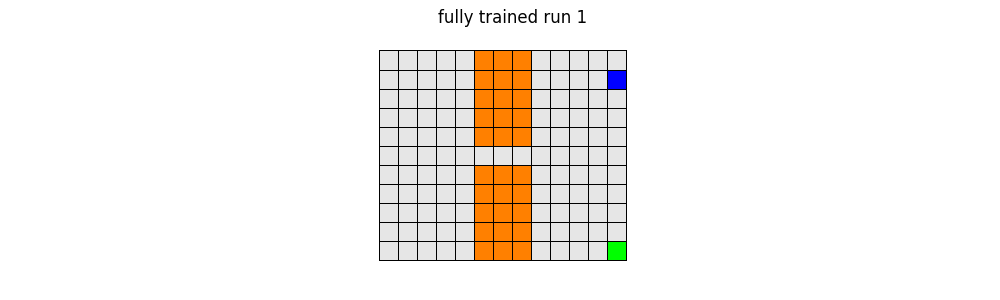
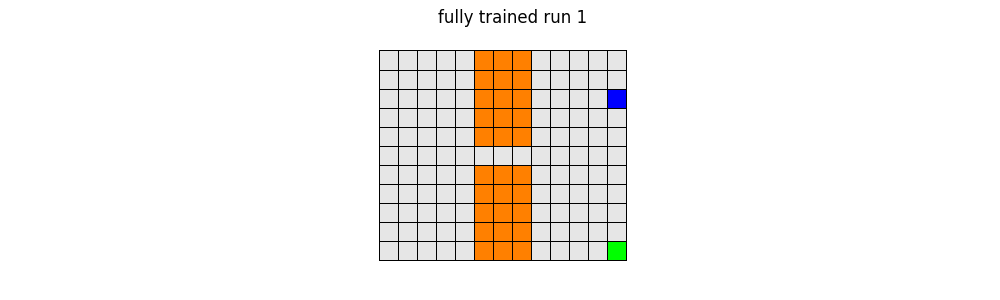
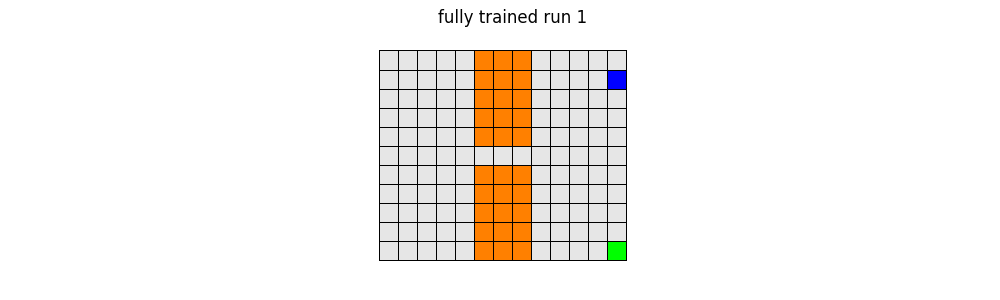
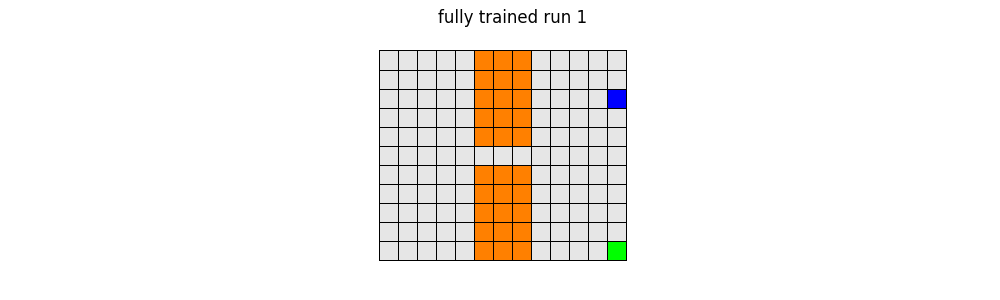
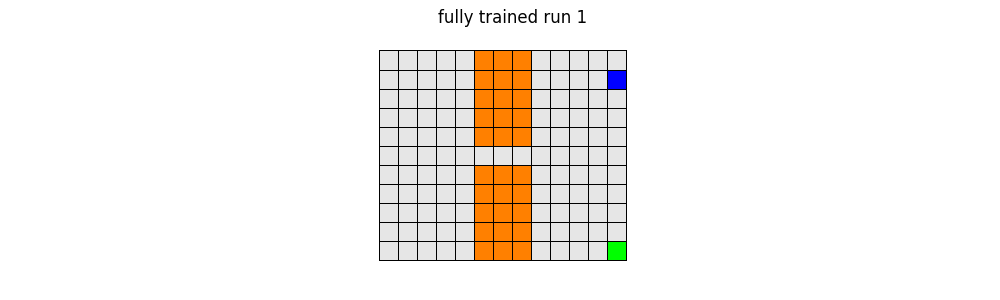
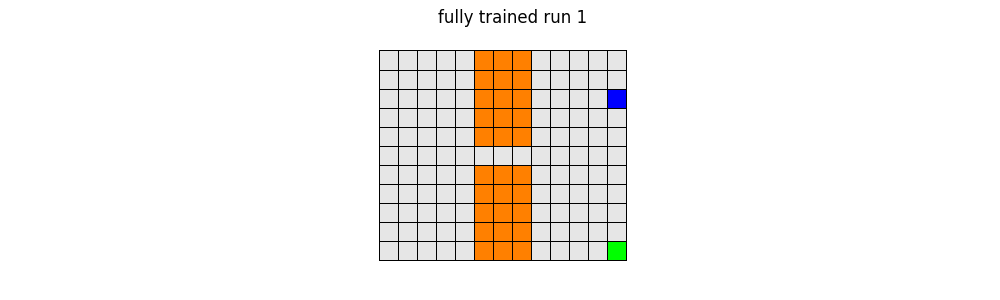
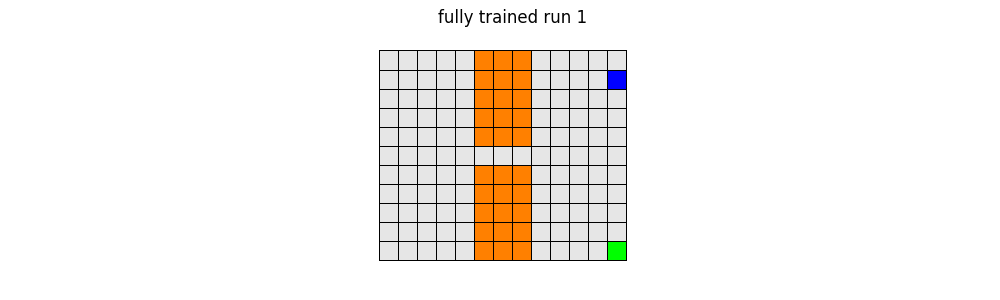
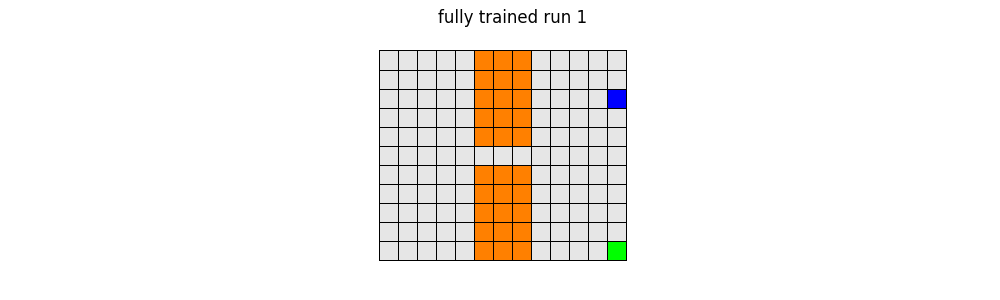
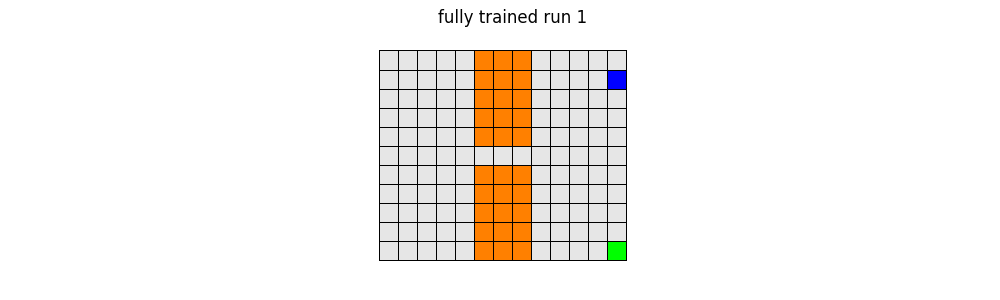
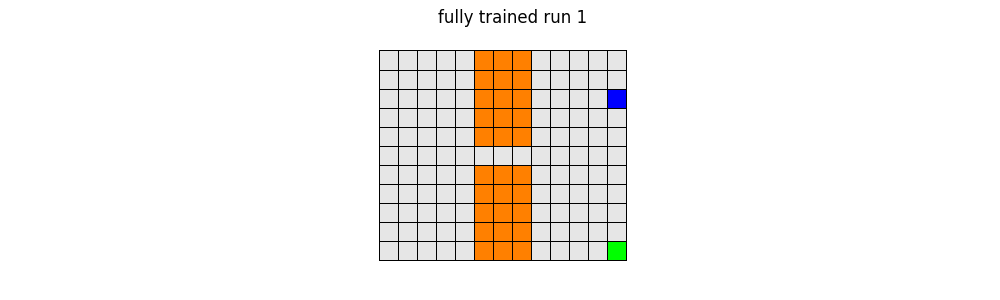
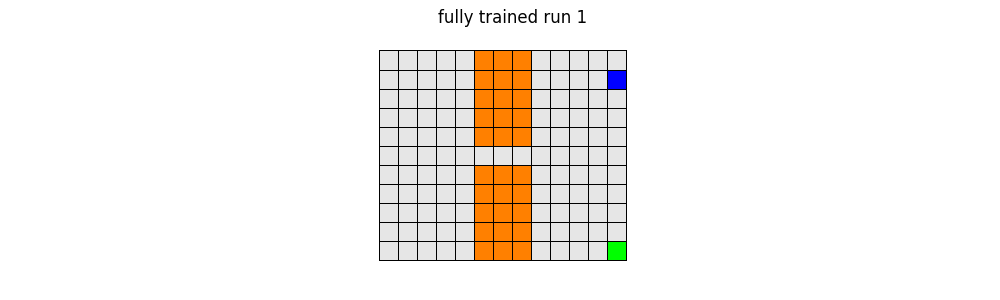
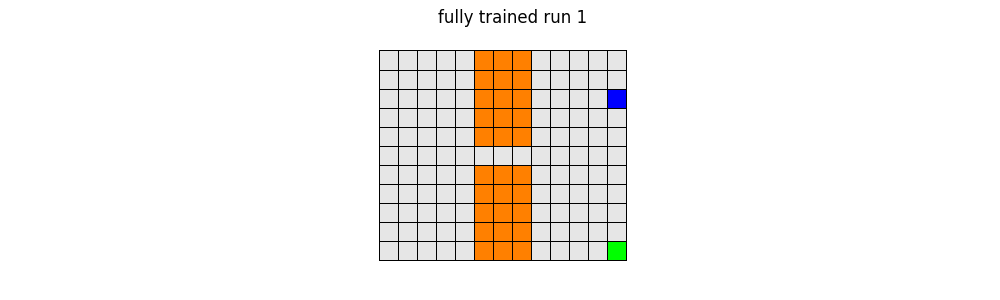
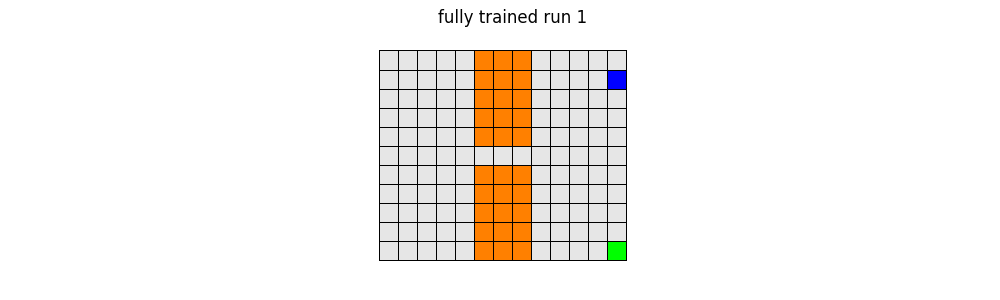
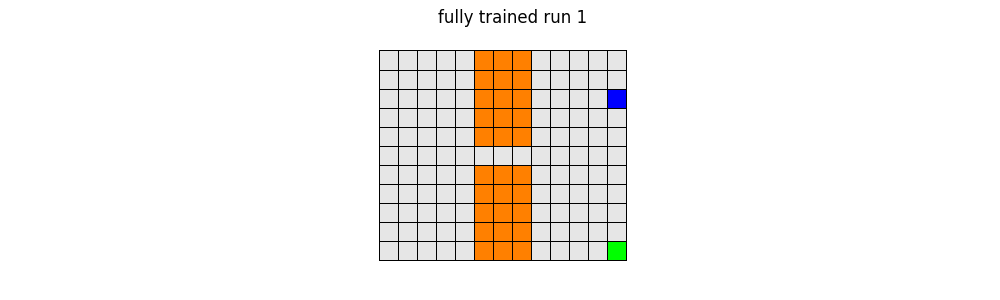
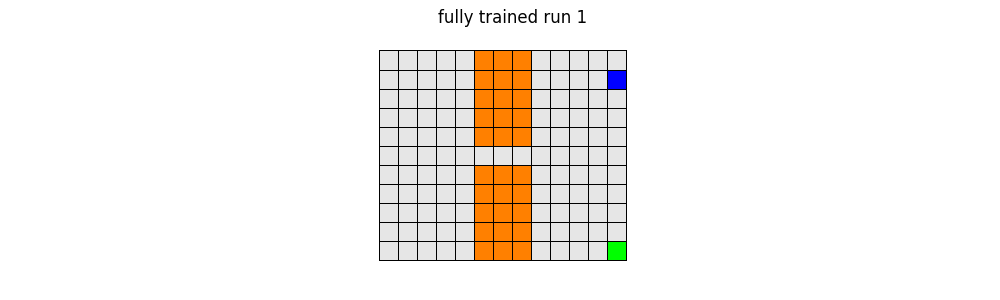
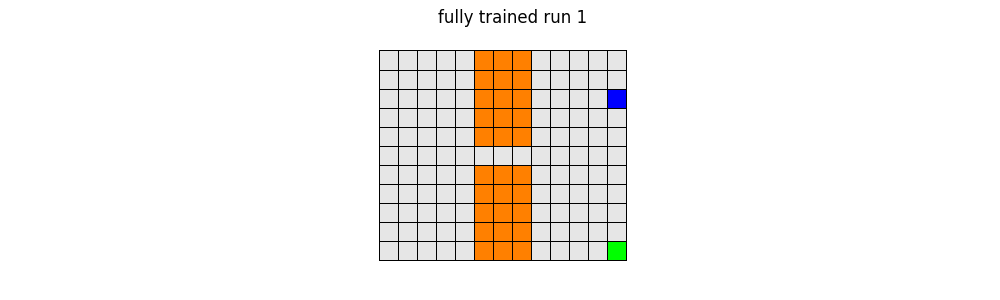
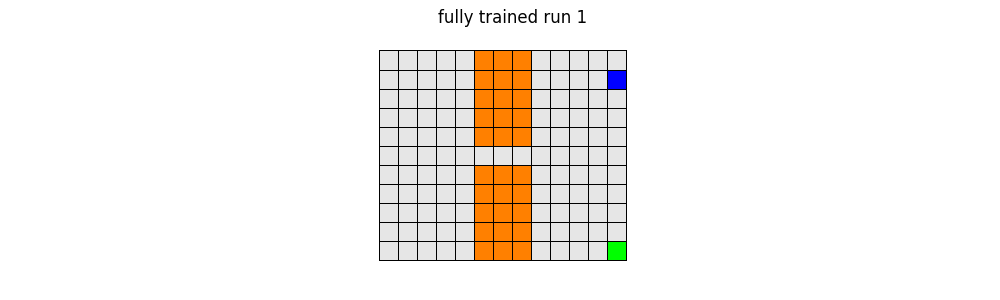
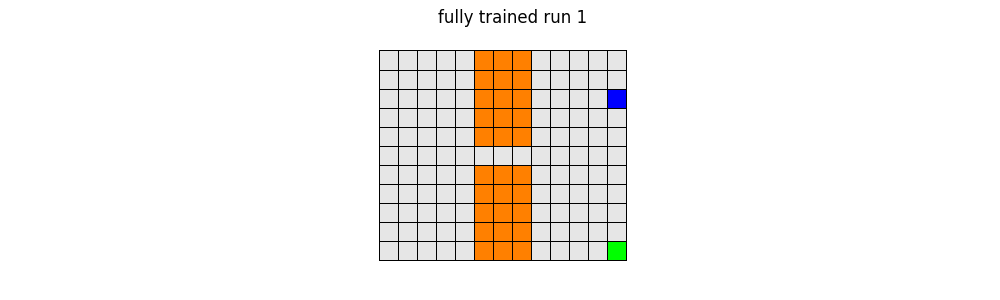
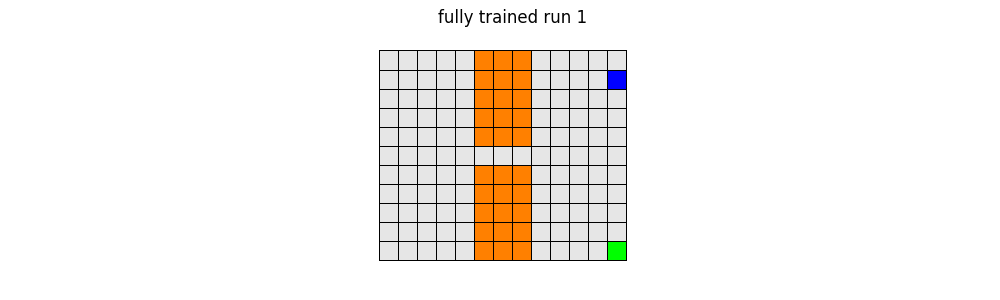
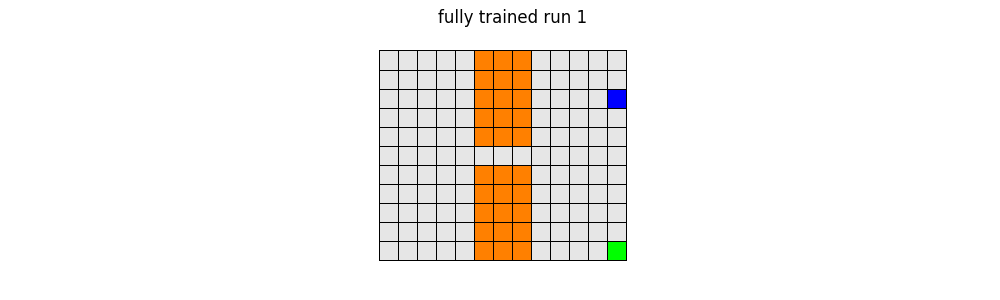
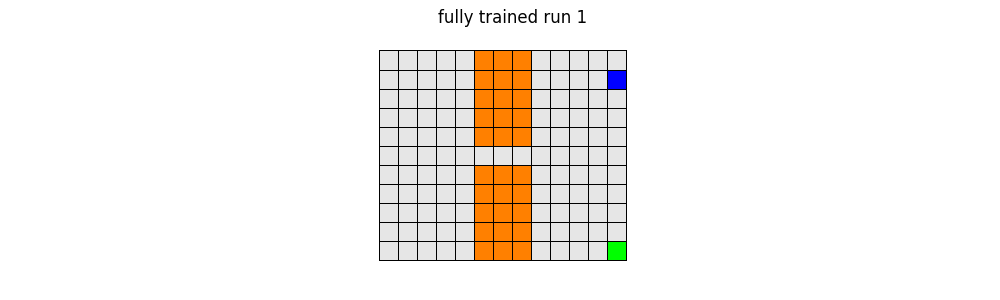
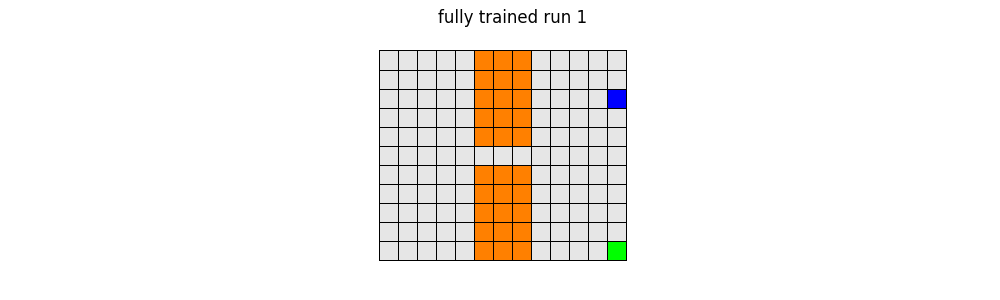
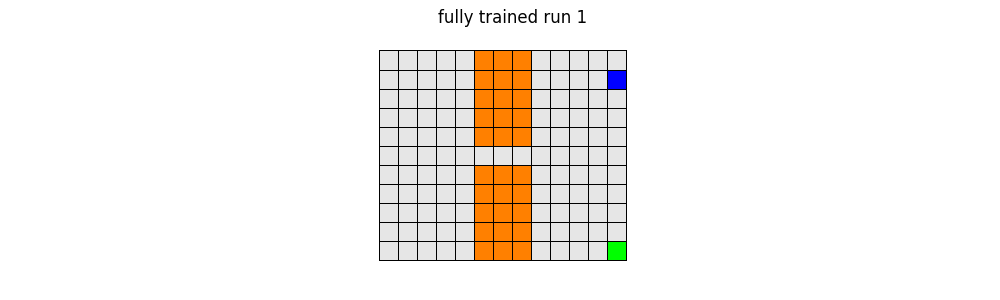
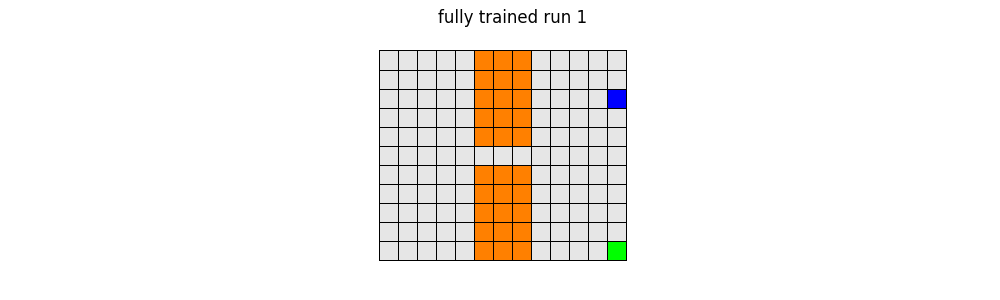
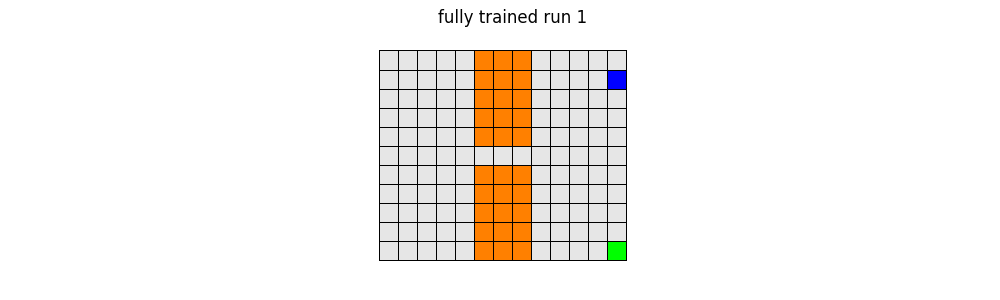
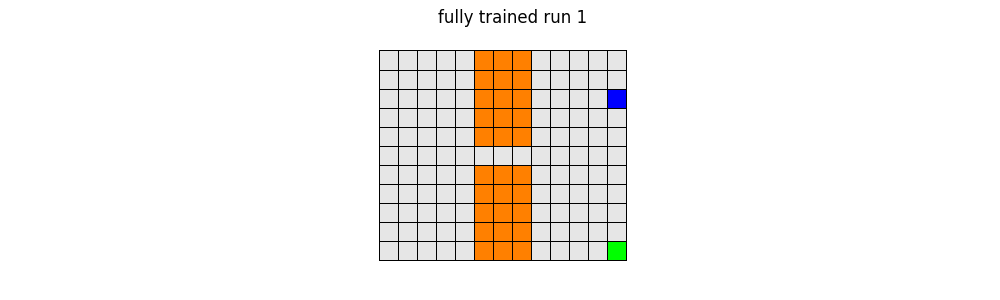
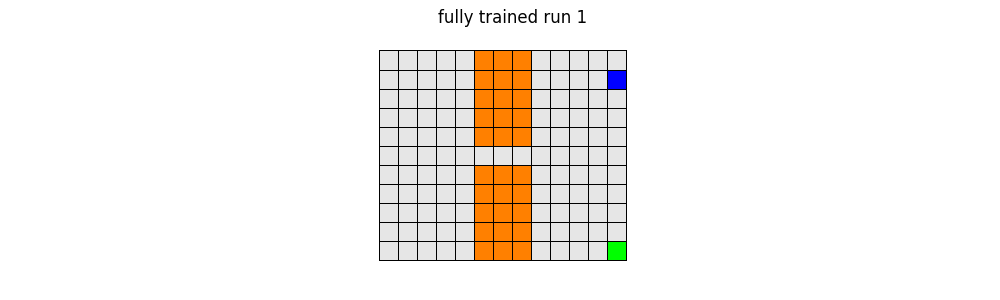
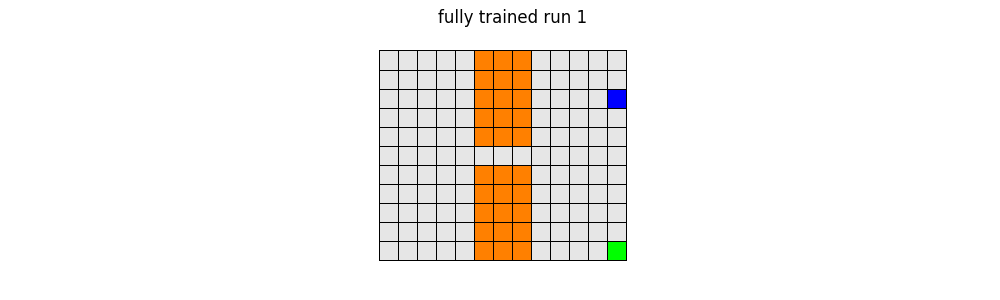
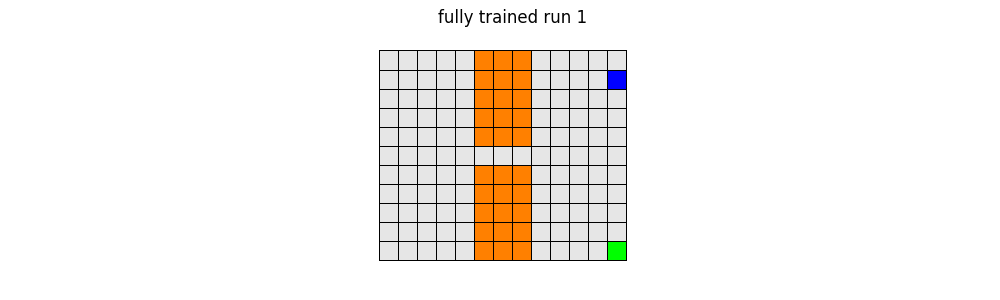
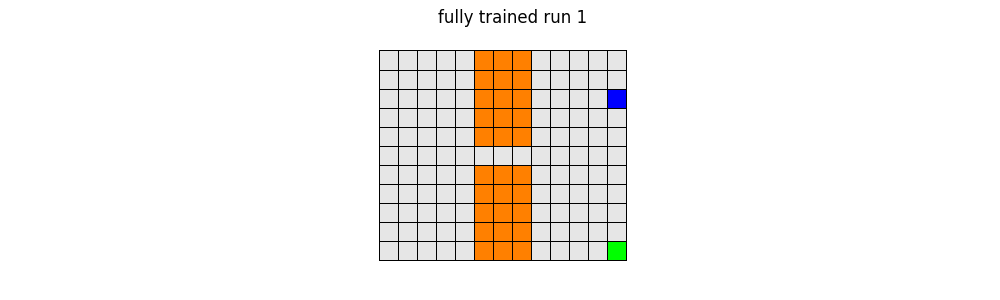
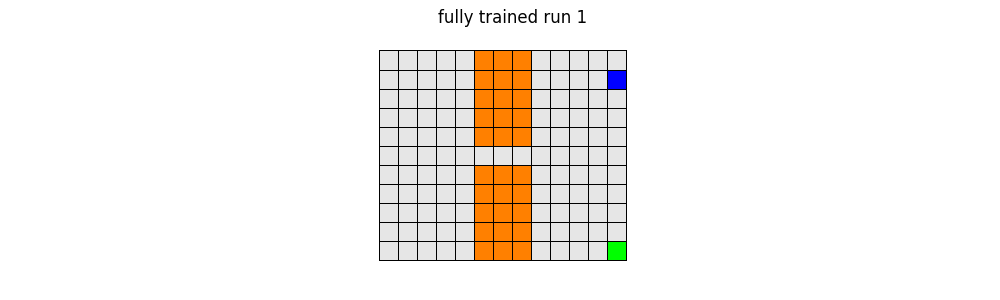
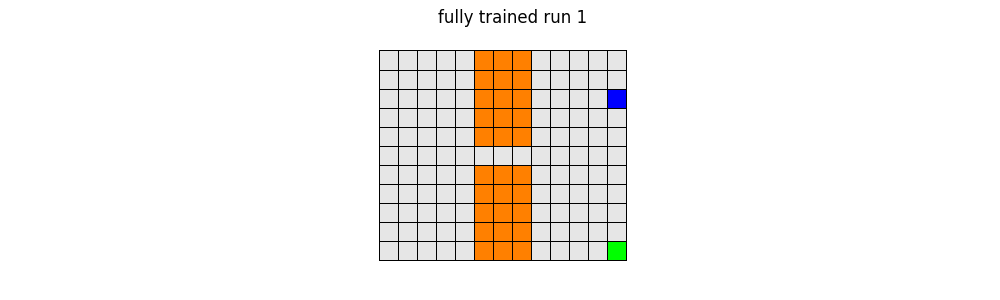
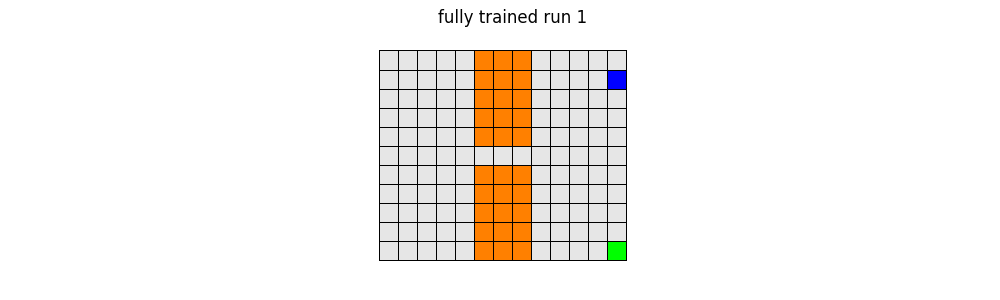
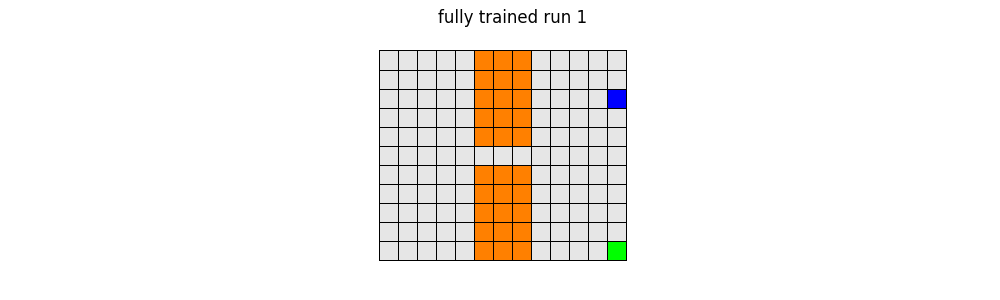
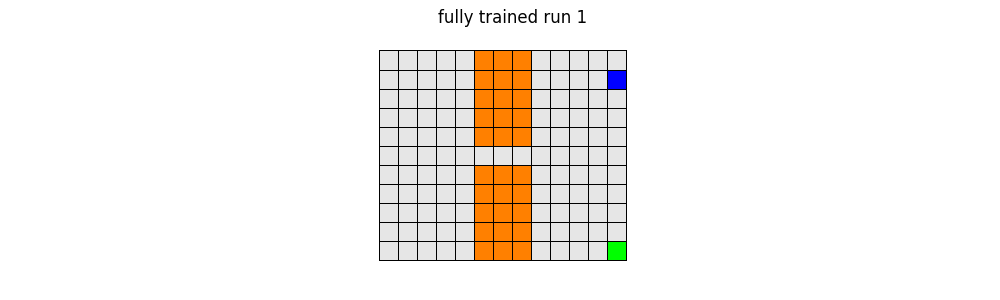
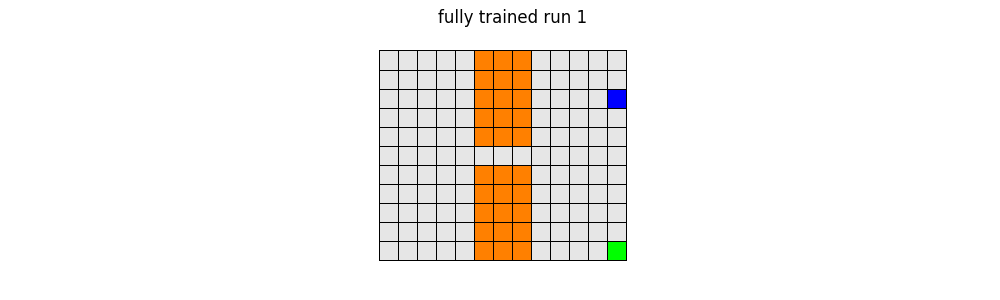
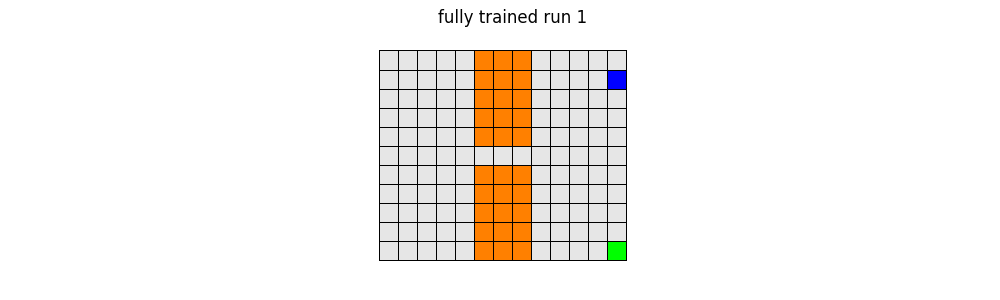
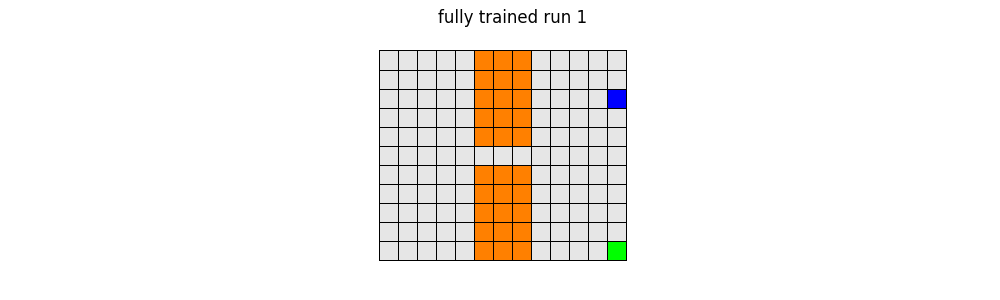
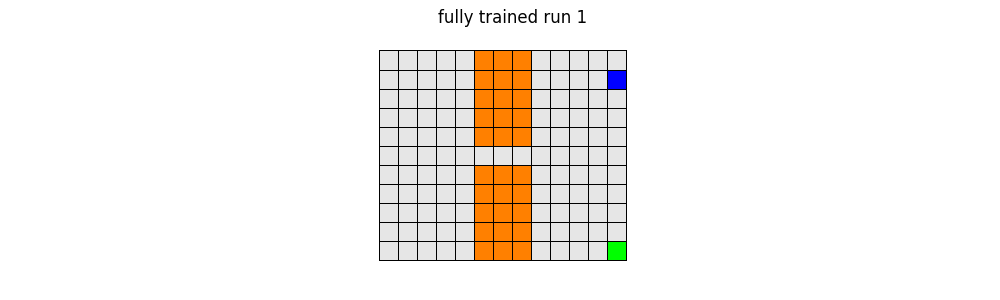
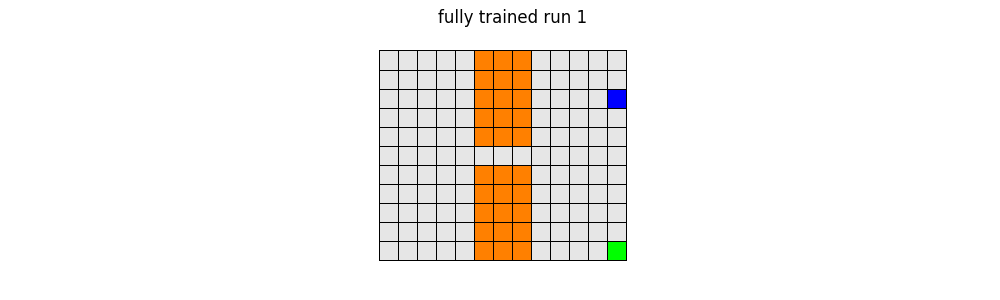
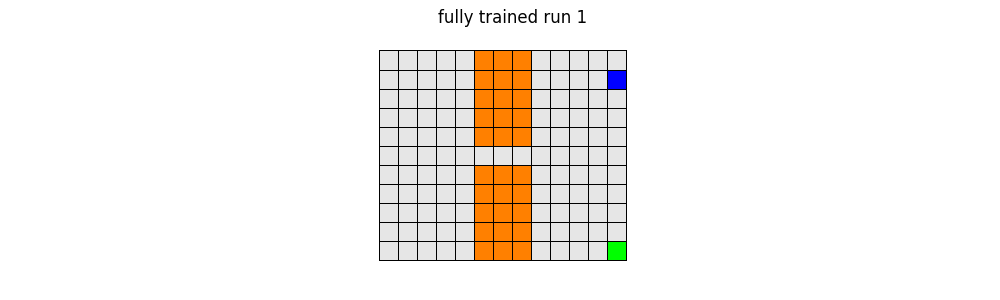
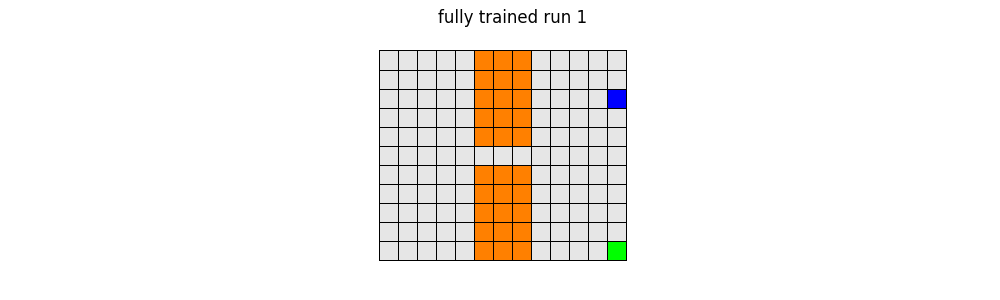
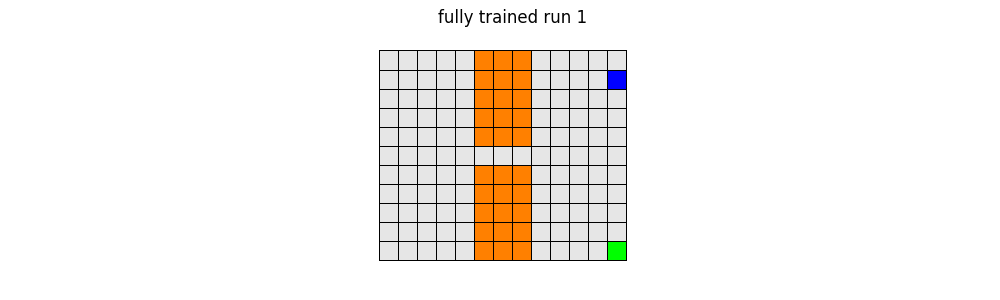
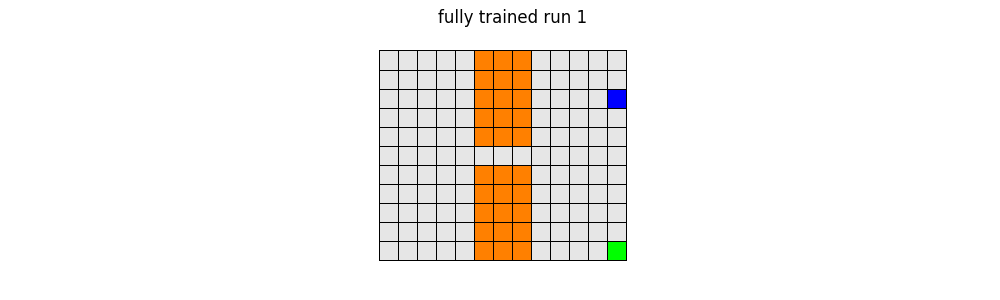
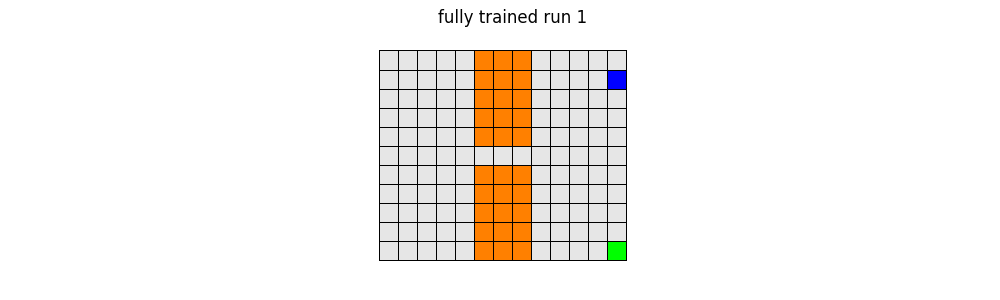
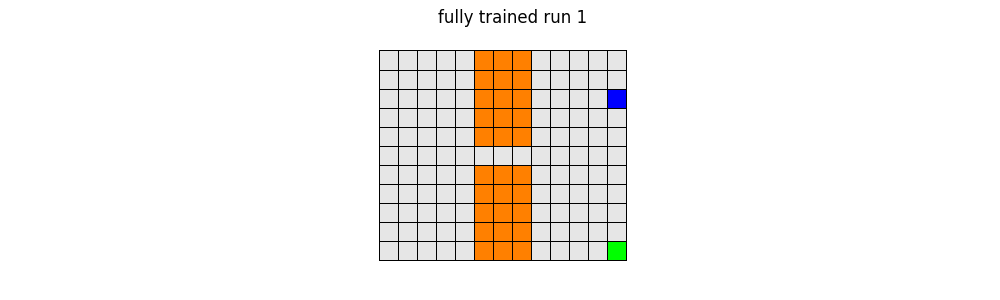
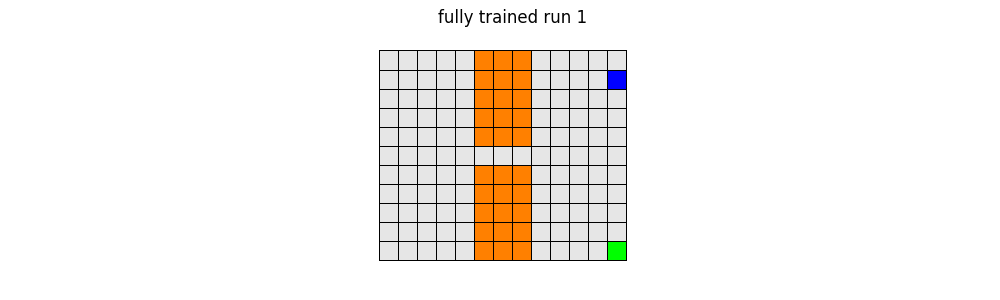
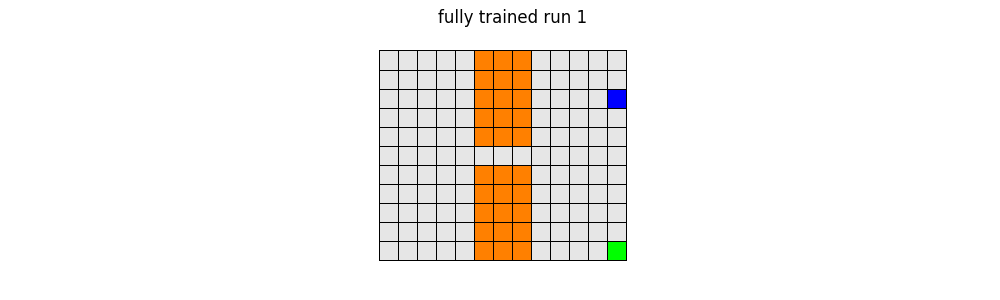
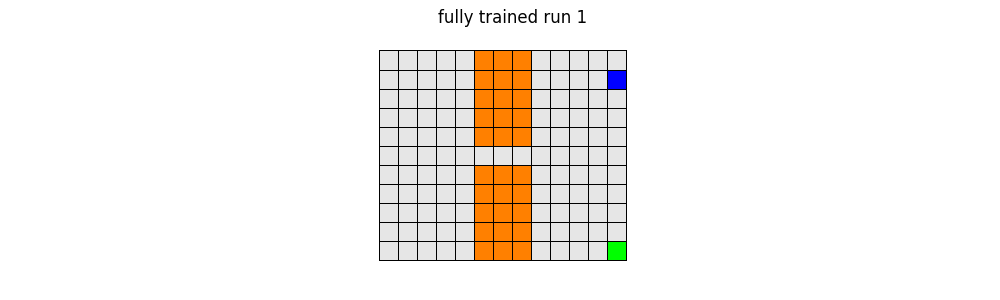
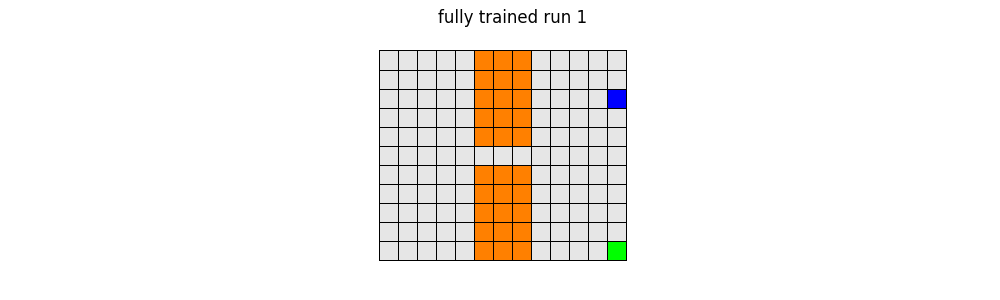
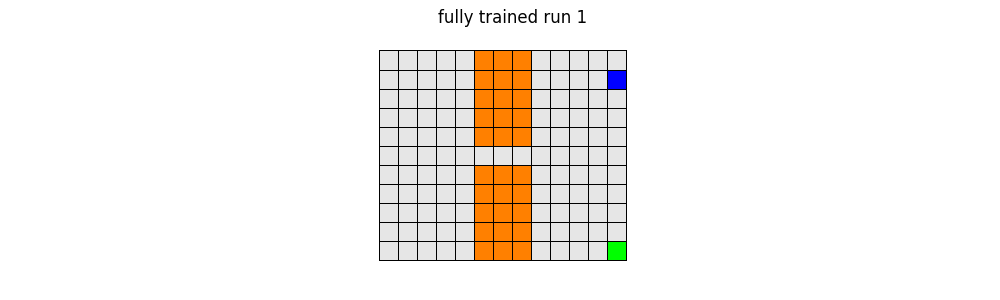
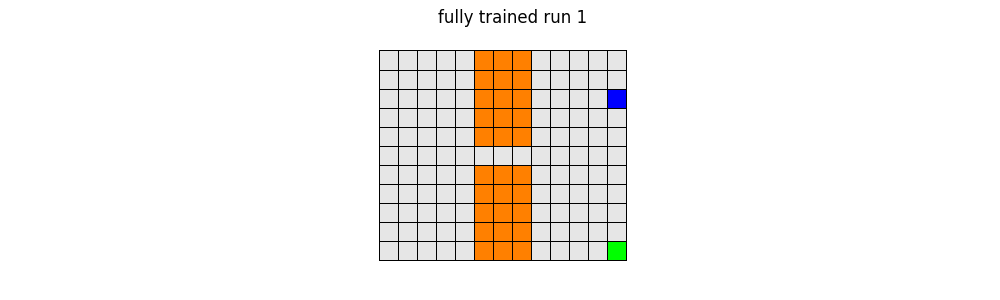
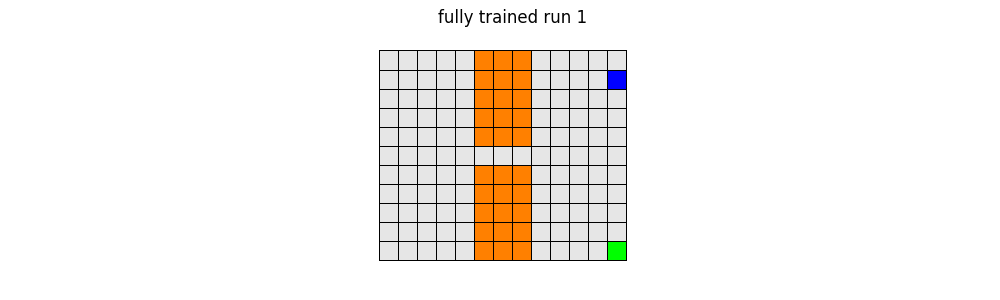
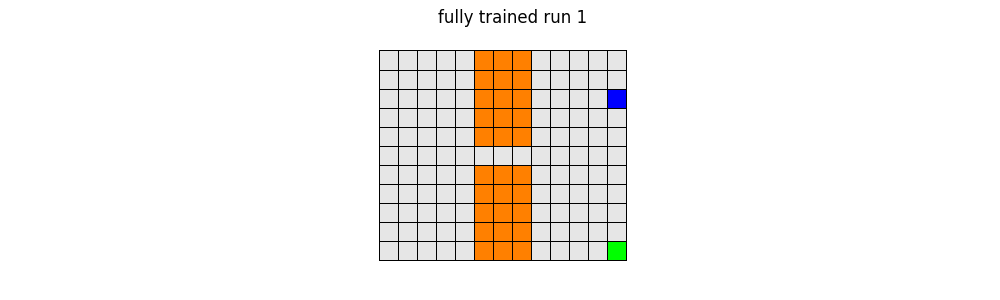
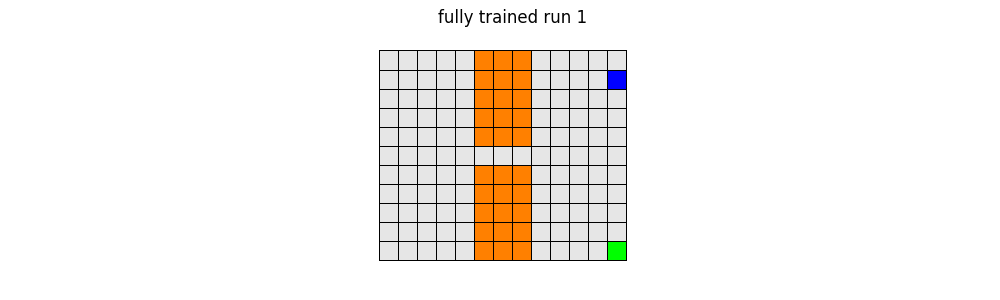
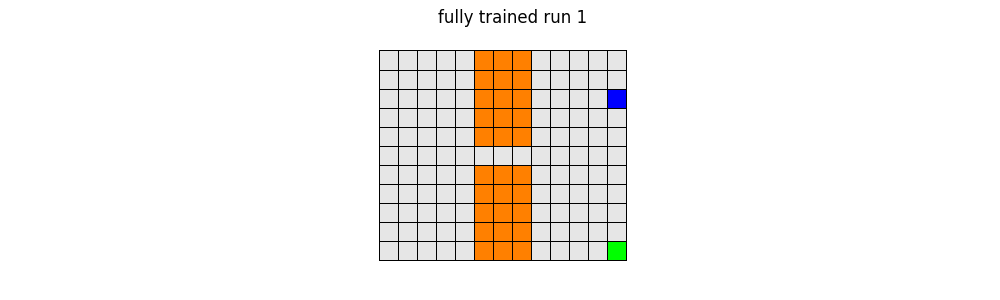
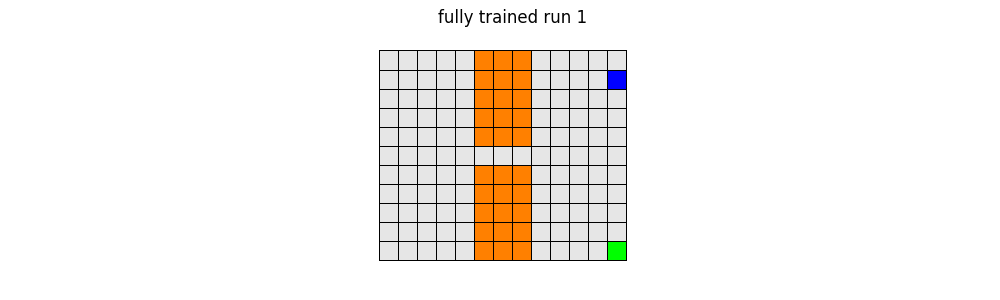

In [6]:
# load in gridworld animation module
from gridworld_lib import gridworld_animators

# create instance of animator
animator = gridworld_animators.animator()

# animate a fully trained agent 
locs = [[0,0]]
animator.animate_validation_runs(gridworld = small_moat,learner = small_maze_qlearner,starting_locations = locs)

Oof!  

The fully trained agent - again, trained on the small enviroment, **not** the small moat enviroment - does not perform well on the small moat enviroment at all!  

Sure the enviroment the agent was trained on was a gridworld - but it was still *very* different than the one we tested the agent on.  Our agent gained **all** of its experience on something very different than what we tested it on.  So - should we be surprised by this 'failing'?  No.   

AI / machine learning is all about creating pattern recognizers that - when trained properly on a dataset - generalize from what they have seen in training to making accurate predictions on new input data.  If a pattern recognizer isn't trained on the sort of data we would like it to recognize in the future we can't expect miracles to happen.  

So generally speaking, we cannot expect an RL agent trained on one enviroment to perform well on another substantially different one.  To demand this is like expecting an object detector - trained to recognize human faces on a large set of images - to accurately detect cars in a new set of images.  In both training and testing we use the same 'enviroment' - images' - but what we want our 'agent' to in each instance is quite different.

# 2.  Simple yet powerful enhancements to Q-Learning

In this section we discuss two simple yet quite powerful enhancements to Q-Learning.  Both of these enhancements help significantly speed up training - which can provide substantial computational savings in practice.  

## 2.1  Short term / long term trad-off parameter

In the first notebook we defined the recursive update equation that lies at the heart of Q-Learning

$$Q\left(s_{k-1},\,a_{k}\right)=r_{k}+\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$$

Remember that in theory the term on the left hand side of the equation $Q\left(s_{k-1},\,a_{k}\right)$ stands for the maximum possible reward we recieve if we start at state $s_{k-1}$ and take action $a_k$.  This is equal to the sum of the two terms on the right hand side above - these are

- $r_k$: which stands for the immediate reward we recieve for taking action $a_k$ starting from state $s_{k-1}$

- $\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$: which stands for the maximum *long term* reward we recieve for taking action $a_k$ starting from state $s_{k-1}$

Of course when we begin training neither term on the left and right involving $Q$ gives us a maximal value - thats why we have to train in the first place!  We always have the immediate reward $r_k$, since this is defined by the enviroment, but when training the maxim

$r_{k}+\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$


\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)

Often in practice one includes a parameter $\gamma \in [0,1]$ to regularize or dampen later rewards and prevent the effect of later actions to interfere with maximal actions in the present state.  Adding this parameter we have an adjusted recursive definition of $Q$ as

$$Q\left(s_{k-1},\,a_{k}\right)=r_{k}+\gamma\cdot\underset{i=1...M}{\text{maximum}}\,\,Q\left(s_{k},\,\alpha_{i}\right)$$

By scaling $\gamma$ up and down we can tune the influence short-term versus long-term rewards have on how $Q$ is learned.  For example:

- When we set $\gamma = 0$ then only the first reward $r_1$ remains. Our agent learns to take a 'greedy' approach to accomplishing our goal, at each state taking the next step that maximizes the next step reward only.


- When we set $\gamma = 1$ then we have our original cost function. 

In [ ]:
# add backend python files to path
import sys
sys.path.append('demo_python_backend_files')
import matplotlib.pyplot as plt

# this line lets us plot in the notebook inline
%matplotlib inline

# import custom gridworld simulator 
from my_gridworld import gridworld


# generate instance of gridworld
small_maze = gridworld(world_size = 'small', world_type = 'random',training_episodes = 20,validation_episodes = 100)

gammas = [0,0.5,1]
rewards = []
for i in range(len(gammas)):
    gamma = gammas[i]
    small_maze.qlearn_v1(gamma = gamma,validate = True)
    rewards.append(small_maze.validation_reward_v1)
    
for i in range(len(gammas)):
    plt.plot(rewards[i][2:])
plt.xlabel('episode')
plt.ylabel('average reward')
plt.title('validation history')
plt.legend(['gamma = ' + str(gammas[0]),'gamma = ' + str(gammas[1]),'gamma = ' + str(gammas[2])],loc='center left', bbox_to_anchor=(1, 0.5))

# 4.  Eexploration / exploitation tradeoff: a fundamental improvement to Q-Learning 

One glaring ineffeciency in the basic Q-Learning algorithm cries out for improvement: how actions are chosen during each step of a training episode.  Remember that in the most basic version of Q-Learning actions are taken *randomly* while training, and then according to the optimal policy when validating.  Because each training episode ends only when a goal state is reached - or a maximum number of steps is taken - choosing actions randomly while training results in hugely ineffecient training.

On the other hand, remember also that the tacit assumption while validating is that the Q function has been properly trained and because of this we can use the recursive definition of the Q function - the optimal policy function - to make an optimal choice of action at each step of validation.    




The basic Q learning algorithm employs random actions to learn the structure of the Q function.  This is approach is very costly in terms of training effeciently.  

Remember the entire goal of Q learning is to - using its recursive definition - iteratively construct the Q function.  

In [36]:
# activate this cell to see the Q learning algorithm used for gridworld above
small_maze = gridworld(world_size = 'small', world_type = 'maze',training_episodes = 200,validation_episodes = 50)  
small_maze.qlearn_v1(validate = True)
small_maze.qlearn_v2(validate = True)

training episode 50 of 200 complete
training episode 100 of 200 complete
training episode 150 of 200 complete
training episode 200 of 200 complete
q-learning version 1 algorithm complete
training episode 50 of 200 complete
training episode 100 of 200 complete
training episode 150 of 200 complete
training episode 200 of 200 complete
q-learning version 2 algorithm complete


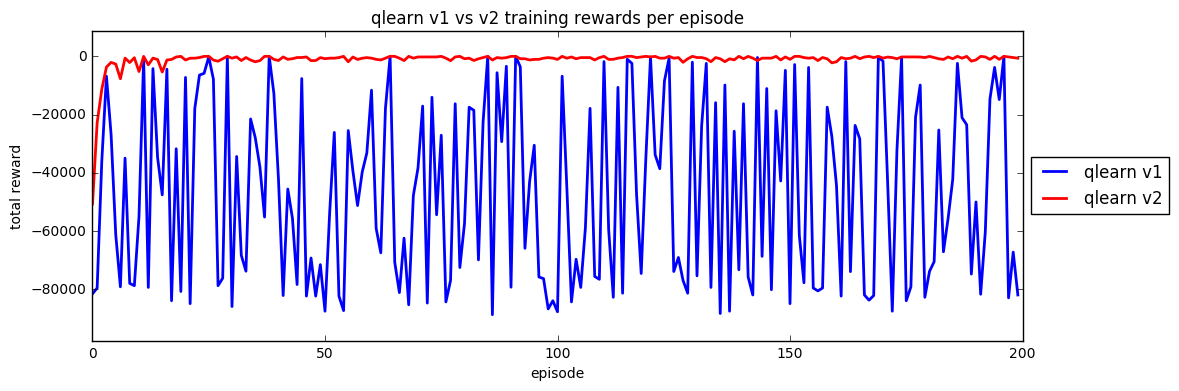

In [37]:
small_maze.compare_v1v2_training_rewards()

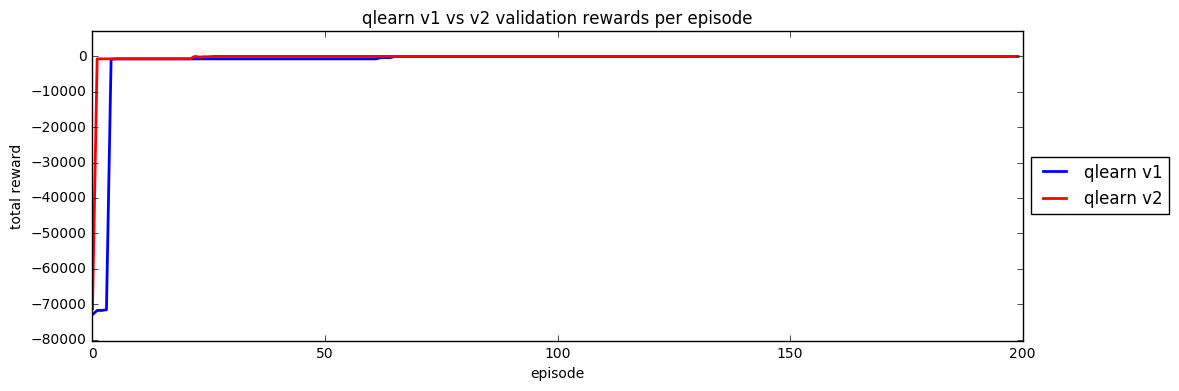

In [38]:
small_maze.compare_v1v2_validation_rewards()

In [1]:
# add backend python files to path
import sys
sys.path.append('demo_python_backend_files')

# this line lets us plot in the notebook inline
%matplotlib inline

# import custom gridworld simulator 
from my_gridworld import gridworld

# generate instance of gridworld
small_maze = gridworld(world_size = 'small', world_type = 'random',training_episodes = 500)

small_maze.qlearn_v1()


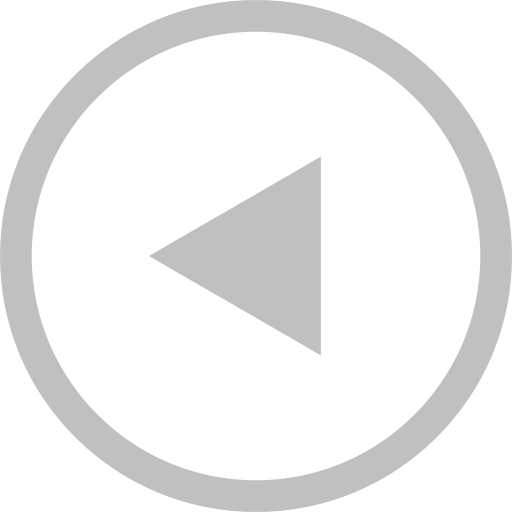
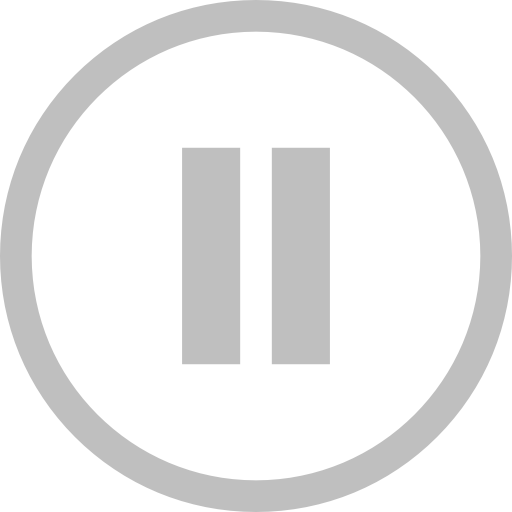
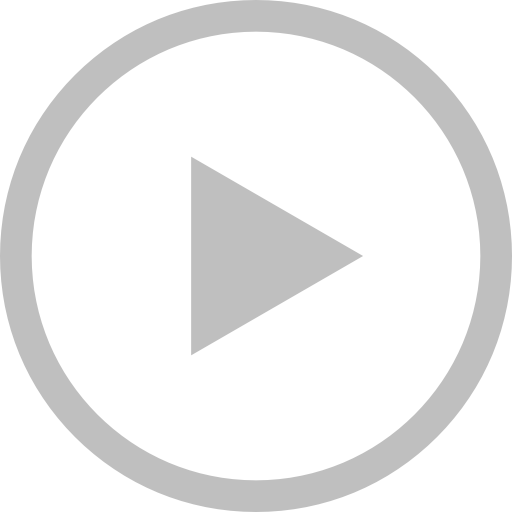
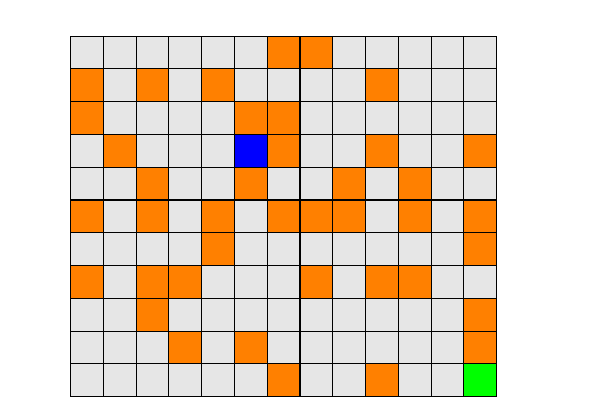
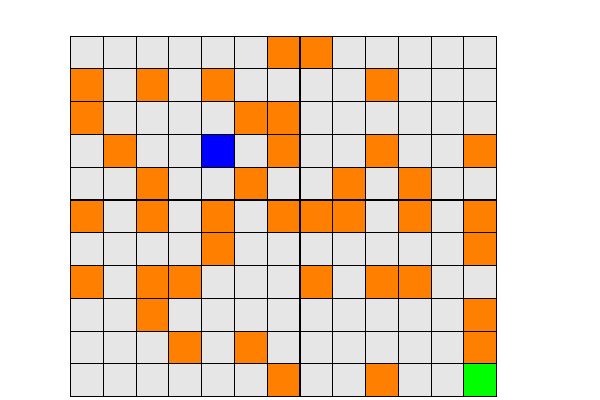
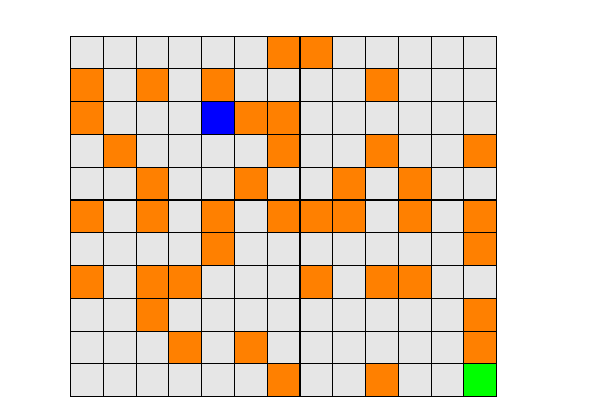
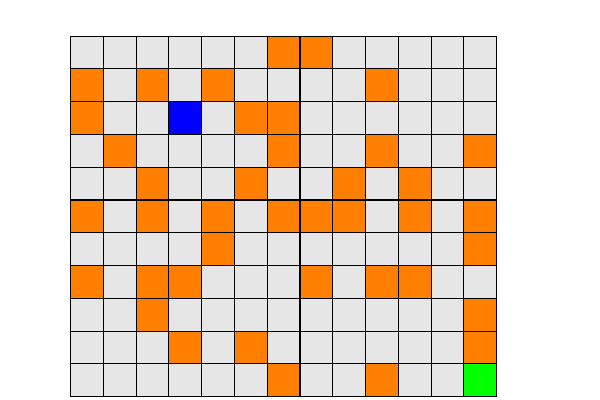
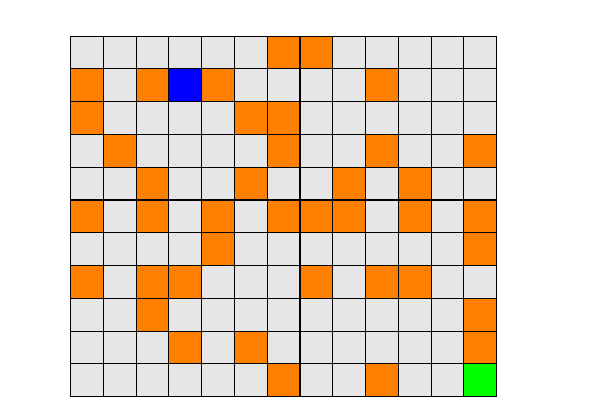
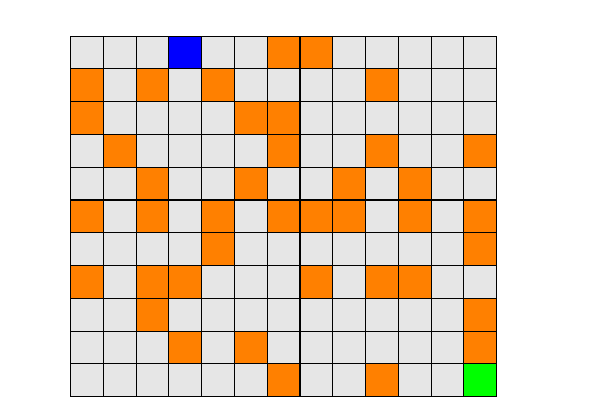
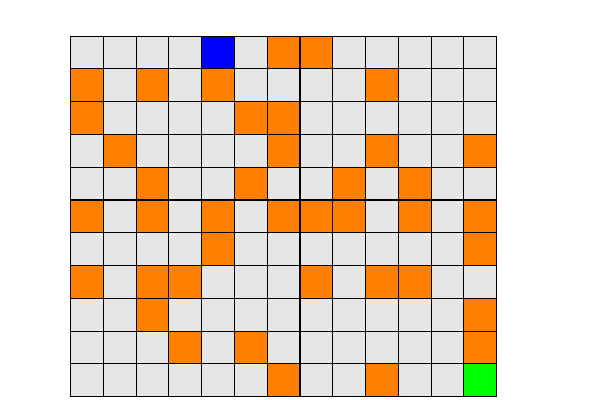
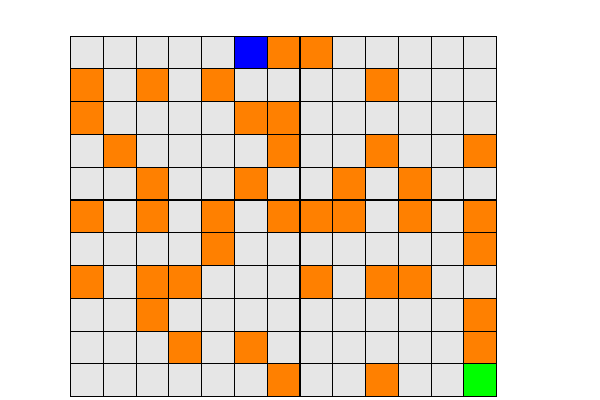
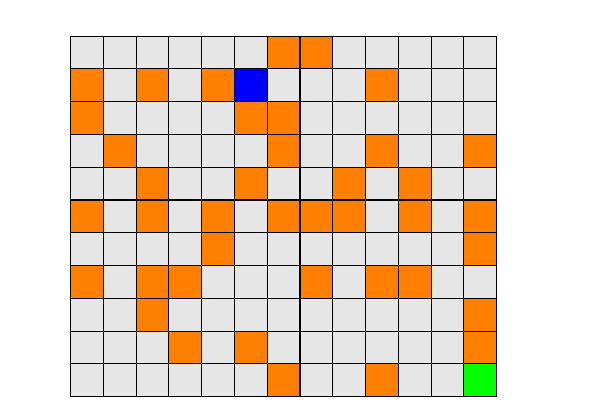
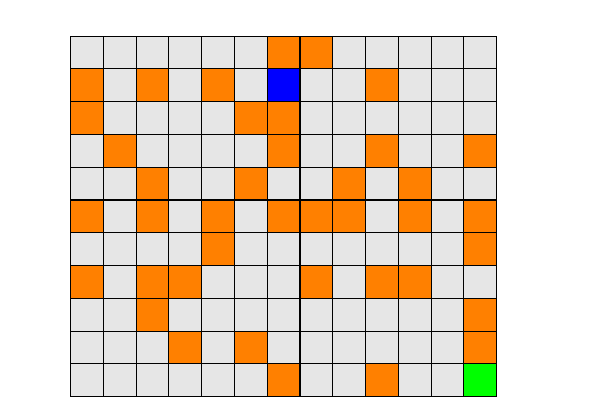
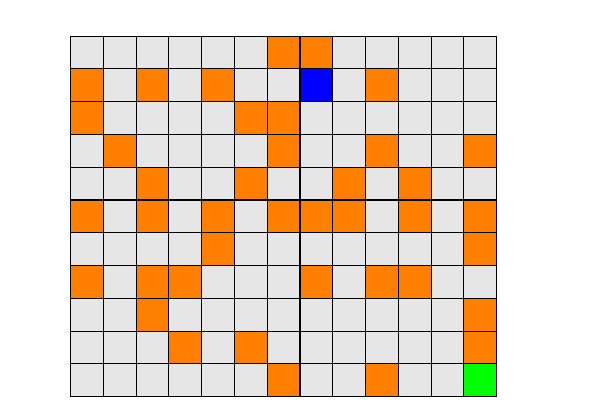
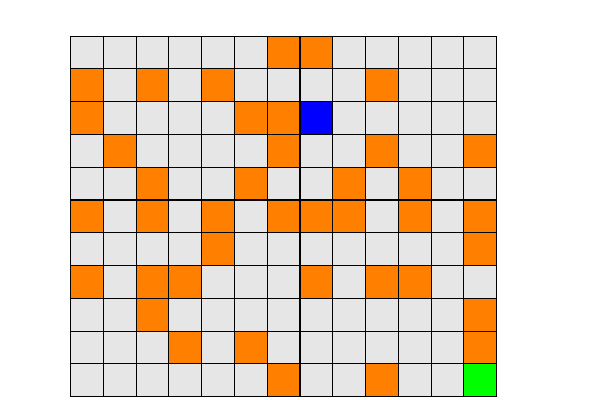
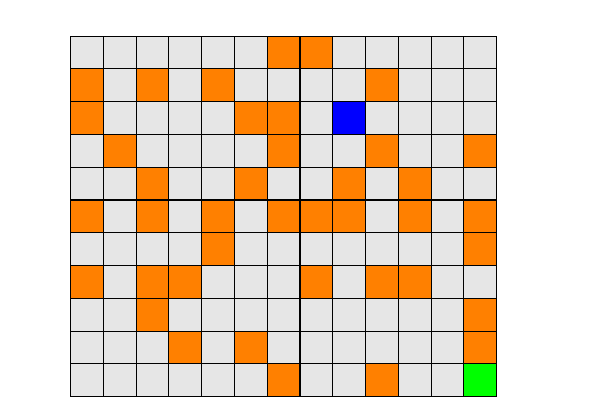
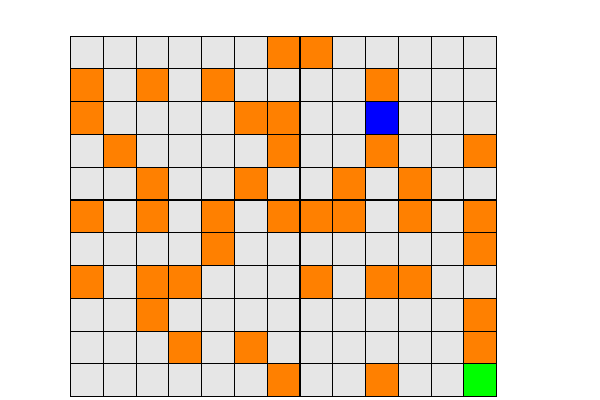
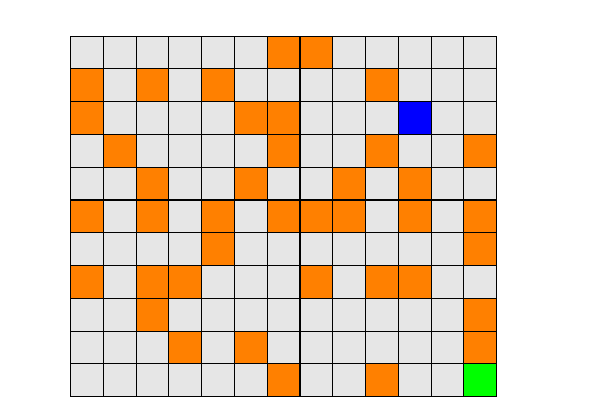
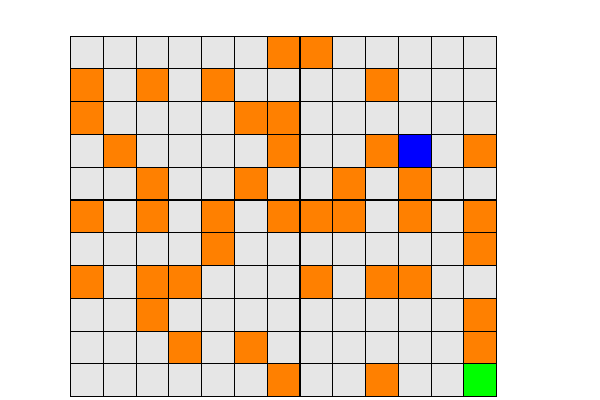
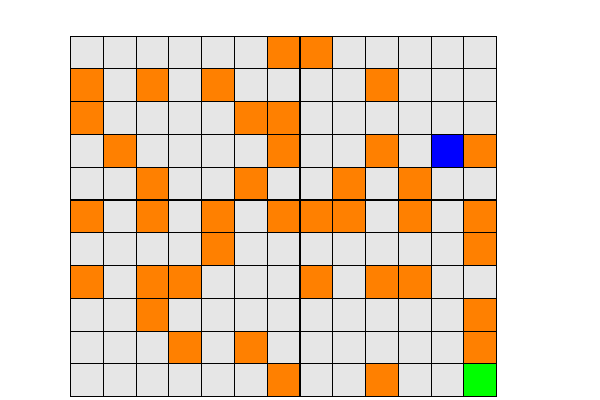
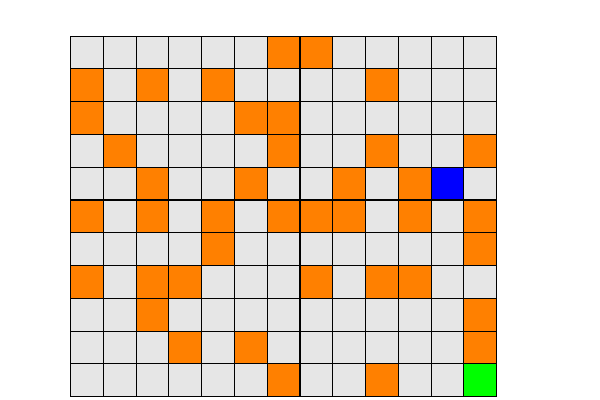
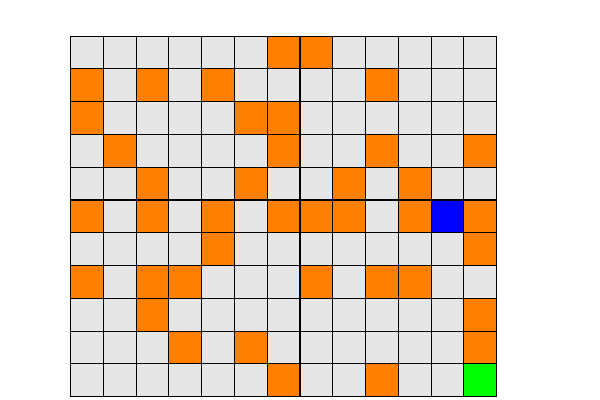
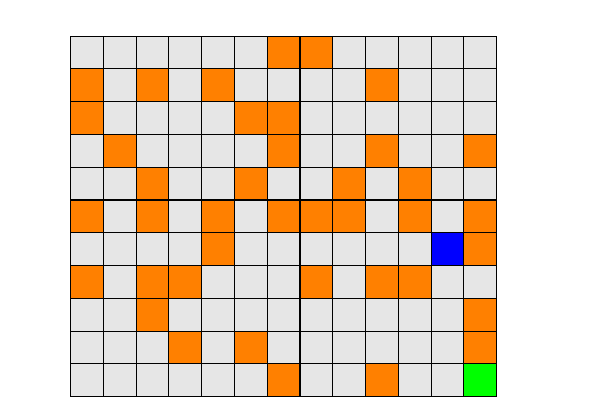
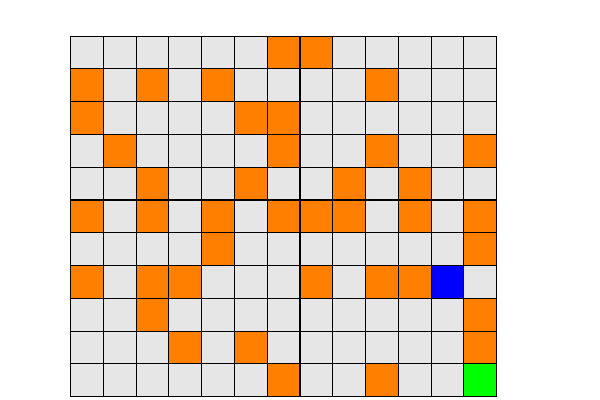
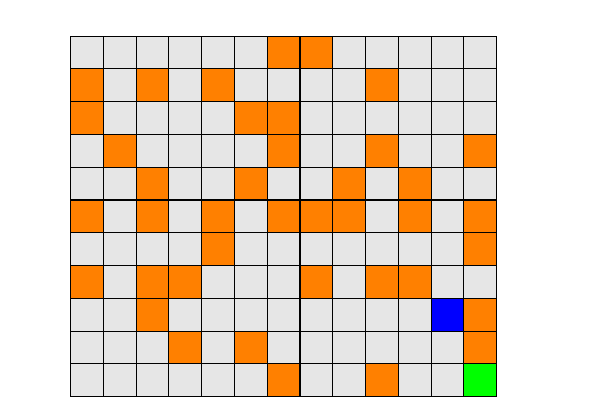
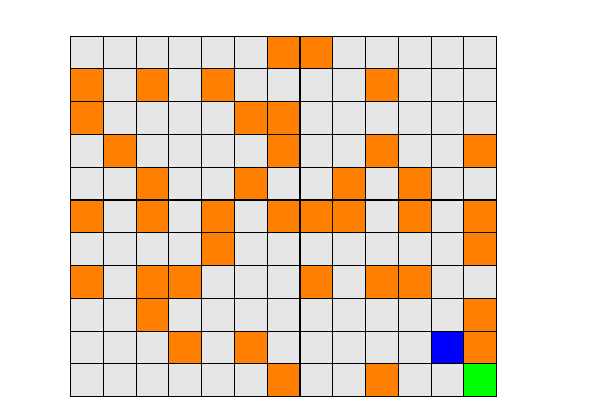
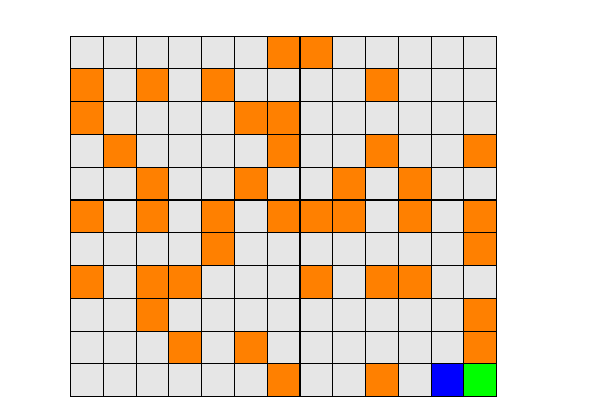
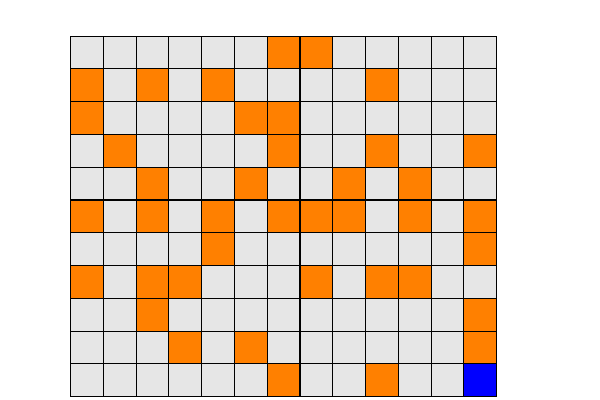

In [3]:
small_maze.animate_trained_run(loc = [7,5],algorithm = 2)

<a id='bib_cell'></a>

## Notes and bibliography

[0] Harmon, Mance E., and Stephanie S. Harmon. Reinforcement Learning: A Tutorial. No. WL-TR-97-1028. WRIGHT LAB WRIGHT-PATTERSON AFB OH, 1997

[1]  There are many algorithms specifically designed to solve just this task - the most popular being [Dijkstra’s and A\* algorithms](http://www.redblobgames.com/pathfinding/a-star/introduction.html).  However the more flexible RL framework too provides great results.

[2] Lai, Matthew. "Giraffe: Using deep reinforcement learning to play chess." arXiv preprint arXiv:1509.01549 (2015).
APA	

[3]  Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013).
    
[4]  Image taken from http://ai.berkeley.edu/project_overview.html

[5] Watkins, Christopher JCH, and Peter Dayan. "Q-learning." Machine learning 8.3-4 (1992): 279-292.

[6]  Image taken from https://gym.openai.com/